In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pdb
import scipy
from scipy.optimize import minimize, fmin
from scipy.stats import multivariate_normal
from tqdm.notebook import tqdm
from scipy import io

import glmnet_python
import scipy, importlib, pprint, matplotlib.pyplot as plt, warnings
from glmnet import glmnet; from glmnetPlot import glmnetPlot 
from glmnetPrint import glmnetPrint; from glmnetCoef import glmnetCoef; from glmnetPredict import glmnetPredict
from cvglmnet import cvglmnet; from cvglmnetCoef import cvglmnetCoef
from cvglmnetPlot import cvglmnetPlot; from cvglmnetPredict import cvglmnetPredict

from PIL import Image
from sklearn.model_selection import train_test_split,KFold
from pyglmnet import GLM, GLMCV, datasets, utils

In [2]:
def gaussian(x, mean, sigma):
    return np.exp(-(x-mean)**2/(2*sigma**2))

def Tones3dgrid(latentTones, sigma):    
    
    input_array_0 = np.expand_dims(gaussian(log_freq_percept, latentTones[0], sigma), axis = 1)
    input_array_1 = np.expand_dims(gaussian(log_freq_percept, latentTones[1], sigma), axis = 1)
    input_array_2 = np.expand_dims(gaussian(log_freq_percept, latentTones[2], sigma), axis = 1)
    s0 = 1/np.sum(input_array_0); 
    s1 = 1/np.sum(input_array_1); 
    s2 = 1/np.sum(input_array_2);
    input_array_0 *= s0; 
    input_array_1 *= s1; 
    input_array_2 *= s2; 
    
    input_array_mat = np.expand_dims(input_array_0@input_array_1.T,axis=2)@(input_array_2.T) #p(T1,T2..|H)   
                                     
    return input_array_mat

def posterior_array(freq_input, n_tones, p_back, p_low, log_prior):
    """
    Arguments: 
    freq_input - range of all possible frequencies (percepts?)
    p_back - prob of background
    p_low - prob of low condition
    log_prior - list of prior parameters
    """
    
    log_prior_low_mean = log_prior[0]; log_prior_low_sigma = log_prior[2];
    log_prior_high_mean = log_prior[1]; log_prior_high_sigma = log_prior[2];
    prior_low = gaussian(x=freq_input, mean=log_prior_low_mean, sigma=log_prior_low_sigma)
    prior_high = gaussian(x=freq_input, mean=log_prior_high_mean, sigma=log_prior_high_sigma)
    prior_dist_mixed_high = p_back*(1/len(freq_input)) + (1-p_back)*prior_high \
    #mixture model with p(T|B) = 1/no. of possible freqs
    prior_dist_mixed_high /= prior_dist_mixed_high.sum() #normalizing
    prior_dist_mixed_high = np.expand_dims(prior_dist_mixed_high, axis = 1)
    prior_dist_mixed_low = p_back*(1/len(freq_input)) + (1-p_back)*prior_low \
    #mixture model with p(T|B) = 1/no. of possible freqs
    prior_dist_mixed_low /= prior_dist_mixed_low.sum() #normalizing
    prior_dist_mixed_low = np.expand_dims(prior_dist_mixed_low, axis = 1)
        
    if n_tones == 3:
        prior_tones_low = np.expand_dims(prior_dist_mixed_low@np.transpose\
                                         (prior_dist_mixed_low),axis=2)@np.transpose(prior_dist_mixed_low) \
        #p(T1,T2..|L) 
        
        prior_tones_high = np.expand_dims(prior_dist_mixed_high@np.transpose\
                                          (prior_dist_mixed_high),axis=2)@np.transpose(prior_dist_mixed_high) \
        #p(T1,T2..|H) 

    elif n_tones == 1:
        prior_tones_low = prior_dist_mixed_low
        prior_tones_high = prior_dist_mixed_high
        
    normalizer = (1-p_low)*prior_tones_high + p_low*prior_tones_low #p(H)*p(T1,T2..|H) + p(L)*p(T1,T2..|L)
    posterior = prior_tones_high*(1-p_low)/normalizer
    # posterior /= np.sum(posterior)
    
    return prior_dist_mixed_high, prior_dist_mixed_low, prior_tones_high, prior_tones_low, normalizer, posterior

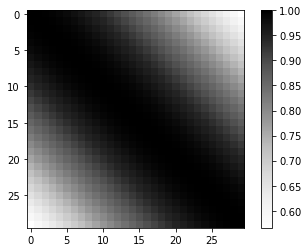

In [3]:
def design_prior_covariance(sigma_tonal=3.):
        '''Design a prior covariance matrix for STRF estimation.
        Args:
            sigma_temporal (float): Standard deviation of temporal prior
                covariance.
            sigma_spatial (float): Standard deviation of spatial prior
                covariance.
        Returns:
            numpy array: 2-d array of size :data:`(n_spatial_basis *
            n_temporal_basis, n_spatial_basis * n_temporal_basis)`, the
            ordering of rows and columns is so that all temporal basis are
            consecutive for each spatial basis.
        '''

        freq_seq = np.arange(90,3000,1) #array of possible true tones
        log_freq_seq_array = np.arange(np.log10(freq_seq[0]), np.log10(freq_seq[-1]), np.log10(1003/1000)*40)
        n_features = len(log_freq_seq_array)
        
        tonal_covariance = np.zeros([n_features, n_features])
        prior_covariance = np.zeros([n_features, n_features])
        for i in np.arange(0, n_features):
            for j in np.arange(i, n_features):
                tonal_covariance[i, j] = np.exp(-1. / (sigma_tonal ** 2) *
                                             (log_freq_seq_array[i] - log_freq_seq_array[j]) ** 2)
                tonal_covariance[j, i] = tonal_covariance[i, j]

        prior_covariance = tonal_covariance
        prior_covariance = 1. / np.max(prior_covariance) * prior_covariance
        return prior_covariance
    

prior_cov = design_prior_covariance(sigma_tonal = 2)

plt.imshow(prior_cov, cmap='Greys', interpolation='none')
plt.colorbar()
plt.show()    

In [4]:
""" 
Obtaining data from a given expt
"""
Test = pd.read_csv('../auditory_categorization_prolific/important_things_not_included_in_assets/allTrials.csv')
Data = pd.read_csv('auditory_categorization_prolific_online_data/human_auditory_categorization_91686_2021-05-20_20h09.05_3a409060-b9a7-11eb-a9da-ac1f6b405aea/5ec3a28f46bca2016fc91c3f_categorization_task_2021-03-01_21h03.59.423.csv');
    
TestLc = pd.read_csv('../auditory_categorization_longLow/important_things_not_included_in_assets/allTrials.csv')
DataLc = pd.read_csv('auditory_categorization_lc_online_data/auditory_categorization_v2_119865_2021-06-11_19h04.17_d1d63a32-cae7-11eb-abb1-ac1f6b405aea/5ec3a28f46bca2016fc91c3f_categorization_task_longLow_2021-03-30_01h15.32.575.csv');

TestHc = pd.read_csv('../auditory_categorization_longHigh/important_things_not_included_in_assets/allTrials.csv')
DataHc = pd.read_csv('auditory_categorization_Hc_online_data/auditory_categorization_v3_143976_2021-06-20_21h31.41_e74189a2-d20e-11eb-abf6-ac1f6b405aea/5ec3a28f46bca2016fc91c3f_categorization_task_longHigh_2021-06-16_10h08.17.055.csv');

In [5]:
def extractData(csv_test, csv_data, exptTotalLength, exptLengthWithBreaks):   
    n_trials = csv_data.shape[0]-47

    test_columns = list(csv_test.columns)
    test_tones_name = test_columns.index('Name')
    test_tones_col_idx = test_columns.index('Tones')
    df_names = (csv_test.iloc[0:exptTotalLength,test_tones_name]).values
    df_tones = (csv_test.iloc[0:exptTotalLength,test_tones_col_idx]).values

    tones_array_orig = np.zeros((n_trials,n_tones))
    tones_array_idxs_keep = []

    for i_wav in range(exptLengthWithBreaks):
        if isinstance(csv_data['Name'][i_wav+46],str):
            tones_array_orig[i_wav,:] = np.array(df_tones[np.where(csv_data['Name'][i_wav+46]\
                                                              ==df_names)[0]][0][1:-1].split(',')).astype(float)  
            tones_array_idxs_keep += [i_wav]


    exptTones = np.copy(tones_array_orig[tones_array_idxs_keep,:])
    exptCorrans = np.copy(csv_data['corrAns'][46:csv_data.shape[0]])[tones_array_idxs_keep]
    exptKeys = np.copy(csv_data['test_resp.keys'][46:csv_data.shape[0]])[tones_array_idxs_keep]
    
    return exptTones, exptCorrans, exptKeys
    

In [6]:
def identifyResponseTrials(keysPressed, correctAns, tonesPlayed, exptTotalLength):
    no_response = np.intersect1d(np.where(keysPressed!='h')[0],
                                 np.where(keysPressed!='l')[0])
    print("Did not respond to: ",no_response)

    """
    Convert keys ['l','h'] to [0,1]
    """

    corrans_num_orig = np.zeros_like(correctAns)
    corrans_num_orig[correctAns == 'h'] = 1

    keys_num_orig = np.zeros_like(keysPressed)
    keys_num_orig[keysPressed == 'h'] = 1

    corrans_num = corrans_num_orig[:exptTotalLength]
    keys_num = keys_num_orig[:exptTotalLength]
    tones_array = tonesPlayed[:exptTotalLength]
    print("Got correct: ", np.sum(keys_num==corrans_num)/len(tones_array))
    print("No. of minority category correct: ", np.sum(keys_num*corrans_num)/np.sum(corrans_num))

    trial_tones = np.repeat(tones_array,1,axis = 0)
    trial_behaviour = np.reshape(keys_num,np.prod(keys_num.shape)) 
    idxs_with_response = np.delete(np.arange(len(trial_tones)),no_response)
    trialTonesResponded = trial_tones[idxs_with_response,:]
    trialBehaviourResponded = trial_behaviour[idxs_with_response]
    corransResponded = corrans_num[idxs_with_response]
    
    return trialTonesResponded, trialBehaviourResponded, corransResponded

"""
Ideal subject behaviour under all three strategies
"""
expt_tones = np.arange(90,3000,1) #array of possible true tones
expt_log_freq_seq_array = np.arange(np.log10(expt_tones[0]), np.log10(expt_tones[-1]), \
                               np.log10(1003/1000)*40)
expt_freq_seq_mid = np.median(expt_log_freq_seq_array)
low_dist = [expt_freq_seq_mid - 0.15,0.1]
high_dist = [expt_freq_seq_mid + 0.15,0.1]


def idealSubjectBehaviour(tonesPresented):
    idealMeanBehaviour = (np.mean(tonesPresented,axis=1)>expt_freq_seq_mid).astype(int) 
    idealVotingBehaviour = (np.sum(tonesPresented>expt_freq_seq_mid,axis=1)>1).astype(int)
    idealSignalMeanBehaviour = np.copy(idealVotingBehaviour)
    for ibehv in range(len(idealSignalMeanBehaviour)):
        if (sum(tonesPresented[ibehv]>high_dist[0]+2*high_dist[1])
              + sum(tonesPresented[ibehv]<low_dist[0]-2*low_dist[1])==3):
            idealSignalMeanBehaviour[ibehv] = np.random.choice([0,1])
        elif (sum(tonesPresented[ibehv]>expt_freq_seq_mid)==2 
              and sum(tonesPresented[ibehv]<expt_freq_seq_mid)==1 
              and sum(tonesPresented[ibehv]>(high_dist[0]+2*high_dist[1]))==1
              and sum(tonesPresented[ibehv]<(low_dist[0]-2*low_dist[1]))==0):
            idealSignalMeanBehaviour[ibehv] = np.random.choice([0,1])
        elif (sum(tonesPresented[ibehv]>expt_freq_seq_mid)==1
              and sum(tonesPresented[ibehv]<expt_freq_seq_mid)==2 
              and sum(tonesPresented[ibehv]>(high_dist[0]+2*high_dist[1]))==0
              and sum(tonesPresented[ibehv]<(low_dist[0]-2*low_dist[1]))==1):
            idealSignalMeanBehaviour[ibehv] = np.random.choice([0,1]) 
        elif (sum(tonesPresented[ibehv]>(high_dist[0]+2*high_dist[1]))==0 
              and sum(tonesPresented[ibehv]>expt_freq_seq_mid)==1
              and sum(tonesPresented[ibehv]<(low_dist[0]-2*low_dist[1]))==2):
            idealSignalMeanBehaviour[ibehv] = 1 
        elif (sum(tonesPresented[ibehv]>(high_dist[0]+2*high_dist[1]))==2 
              and sum(tonesPresented[ibehv]<expt_freq_seq_mid)==1
              and sum(tonesPresented[ibehv]<(low_dist[0]-2*low_dist[1]))==0):  
            idealSignalMeanBehaviour[ibehv] = 0
    return idealMeanBehaviour, idealSignalMeanBehaviour, idealVotingBehaviour


In [7]:
n_tones = 3

"""
Get tones and values of keys pressed from no context expt
"""
df_tones, df_corrans, df_keys = extractData(csv_test=Test, 
                                            csv_data=Data, 
                                            exptTotalLength=600, 
                                            exptLengthWithBreaks=603)    

"""
Get tones and values of keys pressed from long context expt with low category bias
"""
df_toneslc, df_corranslc, df_keyslc = extractData(csv_test=TestLc, 
                                            csv_data=DataLc, 
                                            exptTotalLength=800, 
                                            exptLengthWithBreaks=804) 

"""
Get tones and values of keys pressed from long context expt with high category bias
"""
df_toneshc, df_corranshc, df_keyshc = extractData(csv_test=TestHc, 
                                            csv_data=DataHc, 
                                            exptTotalLength=800, 
                                            exptLengthWithBreaks=804) 


In [8]:
"""
Find no response cases in the no context expt
"""
log_freq_percept = np.arange(0.6,4.7,0.1) 
latent_log_freq_seq_array = np.arange(0.6,4.7,0.1) 

trial_tones_expt, _ , _ = identifyResponseTrials(keysPressed = df_keys, 
                                                correctAns = df_corrans, 
                                                tonesPlayed = df_tones, 
                                                exptTotalLength = 600)
idealSubjMeanBhv, idealSubjSignalMeanBhv, idealSubjVotingBhv = idealSubjectBehaviour(np.log10(trial_tones_expt))



Did not respond to:  []
Got correct:  0.8116666666666666
No. of minority category correct:  0.7840531561461794


In [9]:
expt_tones = np.arange(90,3000,1) #array of possible true tones
log_freq_seq_array = np.arange(0.6,4.7,0.1)
log_freq_percept = np.arange(0.6,4.7,0.1) # array of possible perceptual tones

def betaValuesSim(tones_array,keys_num,
                  alpha,noTau, 
                  permutations):
    
    glmBetas = np.zeros((permutations,31))
    betas = np.zeros((permutations,31))
    GLMScoreTt = 0
    PyGLMScoreTt = 0
    
    kf = KFold(n_splits=permutations)
    nn = 0
    
    for train_index, test_index in kf.split(tones_array):
        # print("TEST:", test_index)
        Xtrain, Xtest = tones_array[train_index,:], tones_array[test_index,:]
        ytrain, ytest = keys_num[train_index], keys_num[test_index]
    
        """
        Train Variables
        """
        trial_tonesTr = np.repeat(Xtrain,1,axis = 0)
        trial_behaviourTr = np.reshape(ytrain,np.prod(ytrain.shape)) 

        """
        Creating lookup table
        """
        uniqueTonesTr = np.unique(tones_array)
        freqTableTr = np.zeros((len(trial_tonesTr),len(uniqueTonesTr)))
        for ii in range(len(trial_tonesTr)):
            for jj in trial_tonesTr[ii]:
                freqTableTr[ii,np.where(uniqueTonesTr==jj)] += 1        

        """
        Test Variables
        """
        trial_tonesTt = np.repeat(Xtest,1,axis = 0)
        trial_behaviourTt = np.reshape(ytest,np.prod(ytest.shape)) 

        """
        Creating lookup table
        """
        uniqueTonesTt = np.unique(tones_array)
        freqTableTt = np.zeros((len(trial_tonesTt),len(uniqueTonesTt)))
        for ii in range(len(trial_tonesTt)):
            for jj in trial_tonesTt[ii]:
                freqTableTt[ii,np.where(uniqueTonesTt==jj)] += 1       

        """
        Cross-validation using glmnet
        """
        plt.figure()
        cvfit = cvglmnet(x = freqTableTr, y = trial_behaviourTr.astype(float),
                         family = 'binomial', ptype = 'class', alpha=alpha)

        #Results of fit
        cvglmnetPlot(cvfit)
        betas[nn] = cvglmnetCoef(cvfit, s='lambda_min').flatten()
        GLMScoreTt += sum(cvglmnetPredict(cvfit, newx=freqTableTt, s='lambda_min', ptype='class').flatten()
                          ==trial_behaviourTt)/len(trial_behaviourTt)

        """
        Cross-validation using pyglmnet
        """

        n_samples = freqTableTr.shape[0]
        """
        tau possibilities 
        """
        #Tau = utils.tikhonov_from_prior(prior_cov, n_samples)

        Tau = np.zeros((len(uniqueTonesTr),len(uniqueTonesTr)))
        for ii in range(len(uniqueTonesTr)):
            Tau[ii,ii] = 2
            if ii < len(uniqueTonesTr)-1:
                Tau[ii,ii+1] = -0.5-1
            if ii > 0:
                Tau[ii,ii-1] = -0.5

        # use the default value for reg_lambda
        glm = GLMCV(distr='binomial', alpha=alpha, Tau=(1-noTau)*Tau[1:-1,:], score_metric='accuracy',tol=1e-4,
                   max_iter=3000)
                
        # fit model
        glm.fit(freqTableTr, trial_behaviourTr.astype(float))

        # score the test set prediction
        #print("PyGLMNet train score: %f" % glm.score(freqTableTr, trial_behaviourTr))
        PyGLMScoreTt += glm.score(freqTableTt, trial_behaviourTt)

        glmBetas[nn,0] = glm.beta0_
        glmBetas[nn,1:] = glm.beta_
        
        nn+=1
    
    print(alpha, [GLMScoreTt/permutations, PyGLMScoreTt/permutations])
    
    return(uniqueTonesTr, betas, np.array(glmBetas), GLMScoreTt/permutations, PyGLMScoreTt/permutations)

/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: C

0.0 [0.9633333333333335, 0.9816666666666667]


/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: C

0.0 [0.9466666666666665, 0.9483333333333335]


<ipython-input-9-f57aad49f320>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: Mat

0.0 [0.9966666666666667, 0.9916666666666666]


/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: C

0.1 [0.9783333333333333, 0.9116666666666667]


/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: C

0.1 [0.9483333333333333, 0.9416666666666667]


/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: C

0.1 [0.9966666666666667, 0.9416666666666667]


/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: C

0.2 [0.9766666666666668, 0.8466666666666665]


/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: C

0.2 [0.9400000000000001, 0.9366666666666668]


/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: C

0.2 [0.9966666666666667, 0.9283333333333333]


/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: C

0.30000000000000004 [0.9766666666666666, 0.7883333333333333]


/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: C

0.30000000000000004 [0.945, 0.9349999999999999]


/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: C

0.30000000000000004 [0.9966666666666667, 0.9233333333333332]


/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: C

0.4 [0.9766666666666666, 0.7733333333333333]


/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: C

0.4 [0.9466666666666665, 0.9349999999999999]


/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: C

0.4 [0.9966666666666667, 0.9216666666666665]


/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: C

0.5 [0.9783333333333333, 0.7733333333333333]


/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: C

0.5 [0.945, 0.9333333333333333]


/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: C

0.5 [0.9966666666666667, 0.9116666666666667]


/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: C

0.6000000000000001 [0.9733333333333333, 0.7716666666666667]


/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: C

0.6000000000000001 [0.9433333333333331, 0.925]


/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: C

0.6000000000000001 [0.9966666666666667, 0.9083333333333334]


/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: C

0.7000000000000001 [0.9766666666666666, 0.7566666666666666]


/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: C

0.7000000000000001 [0.9433333333333331, 0.9099999999999999]


/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: C

0.7000000000000001 [0.9966666666666667, 0.9066666666666666]


/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: C

0.8 [0.9783333333333332, 0.7566666666666666]


/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: C

0.8 [0.9416666666666667, 0.9]


/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: C

0.8 [0.9966666666666667, 0.9049999999999999]


/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: C

0.9 [0.9783333333333332, 0.7383333333333334]


/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: C

0.9 [0.945, 0.9016666666666666]


/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: C

0.9 [0.9966666666666667, 0.89]


/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: C

1.0 [0.9783333333333332, 0.7216666666666667]


/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: C

1.0 [0.9433333333333331, 0.9]


/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: C

1.0 [0.9966666666666667, 0.875]


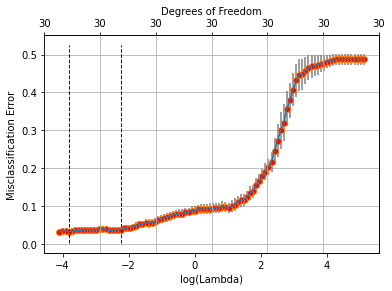

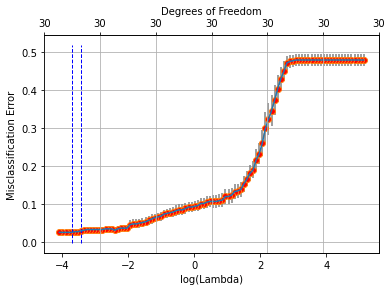

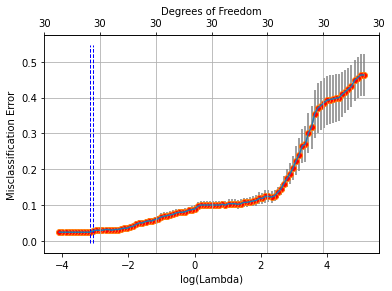

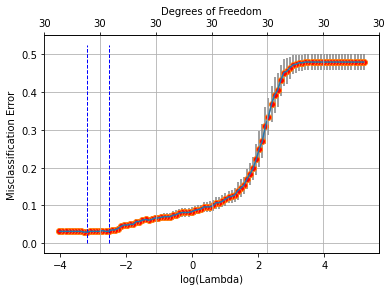

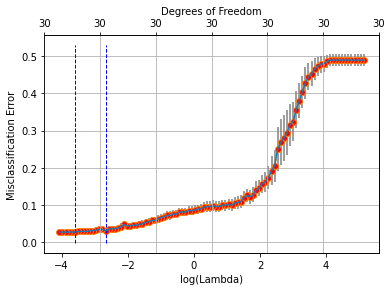

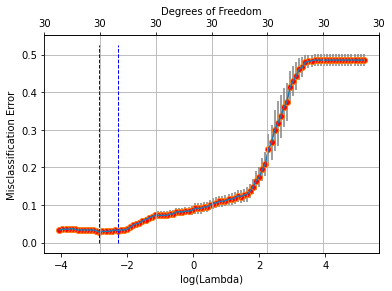

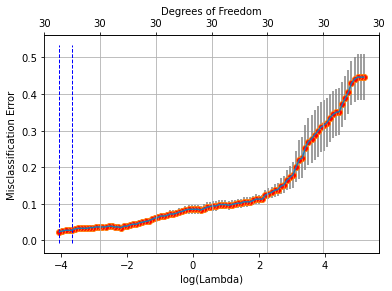

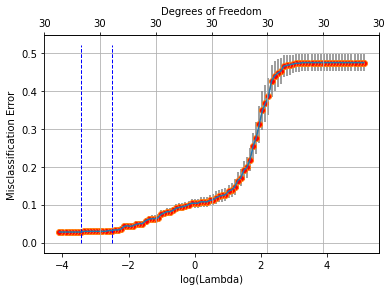

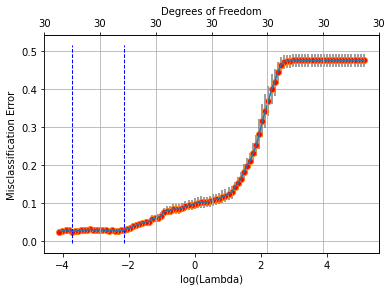

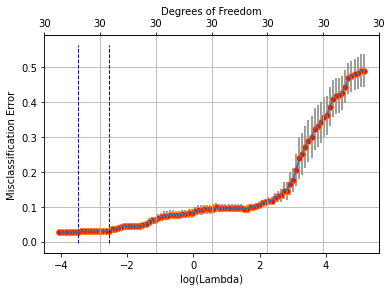

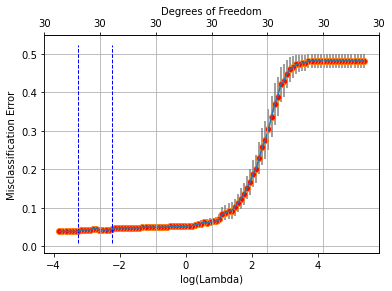

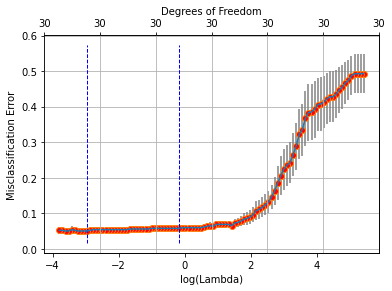

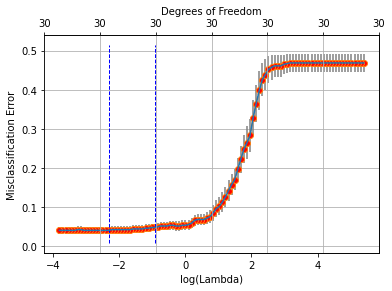

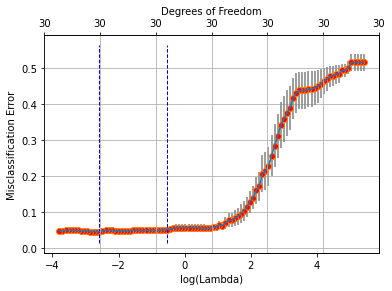

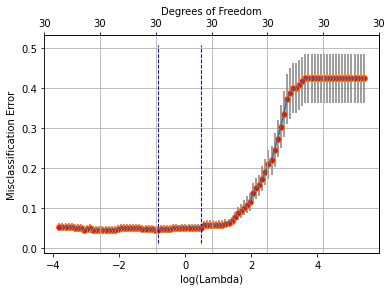

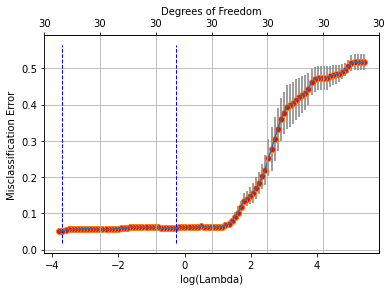

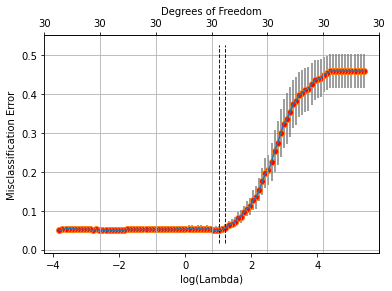

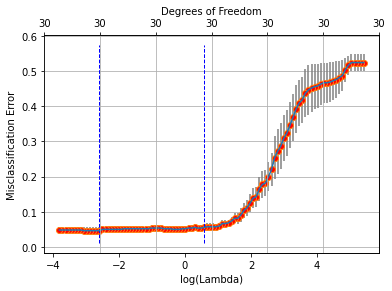

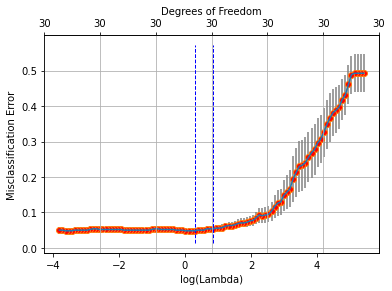

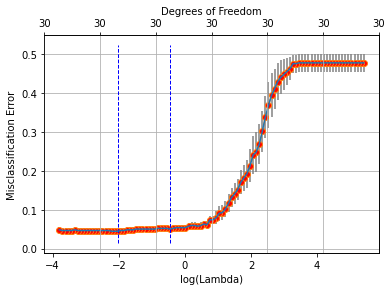

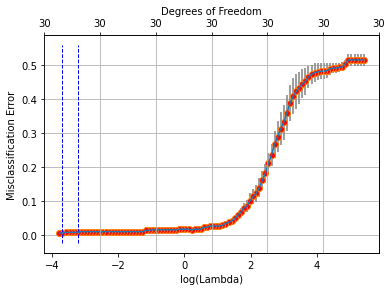

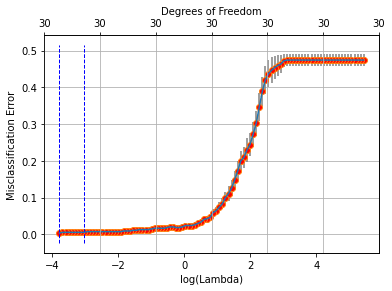

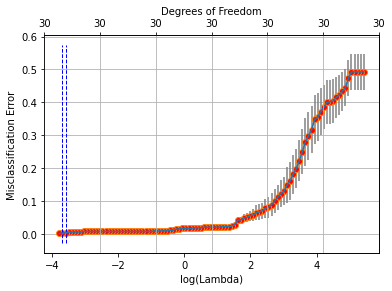

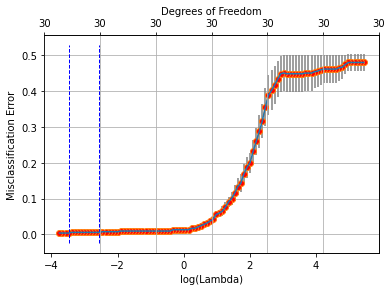

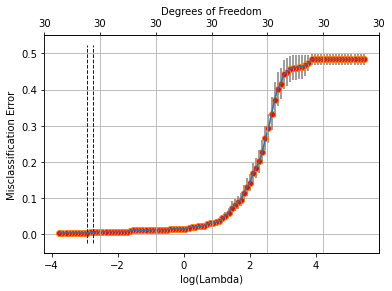

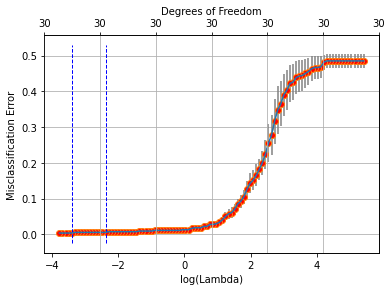

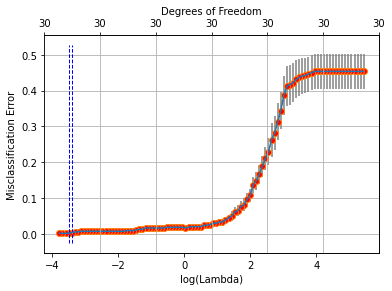

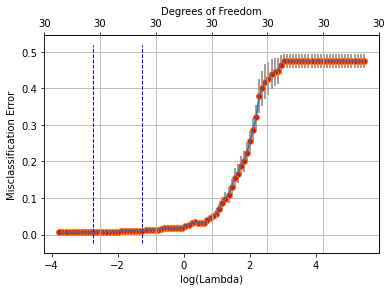

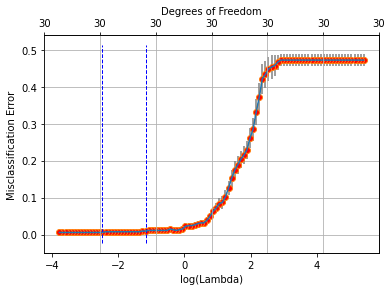

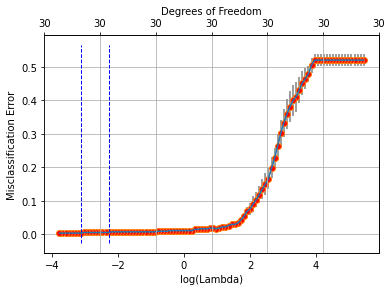

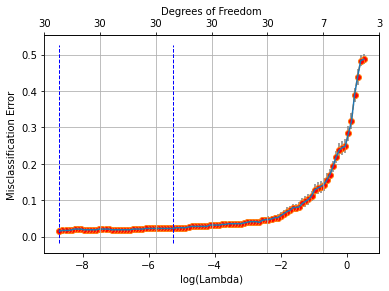

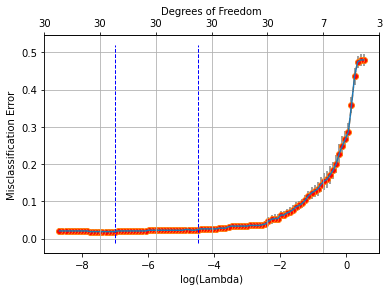

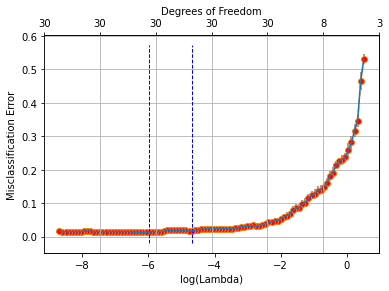

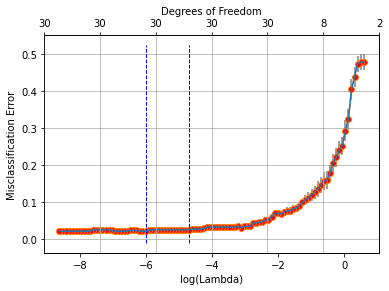

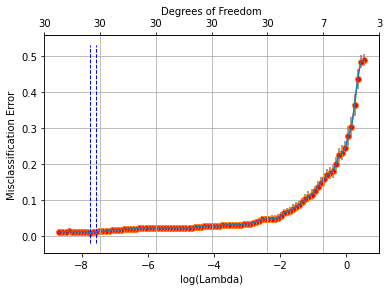

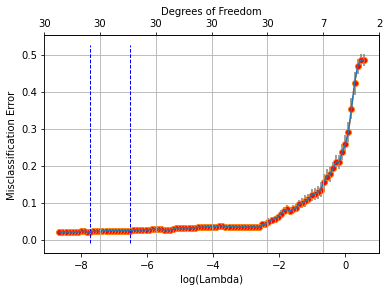

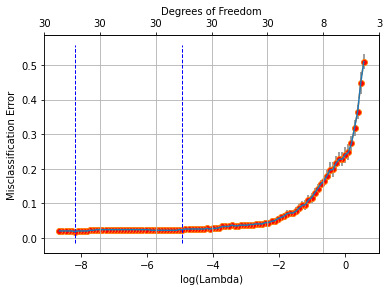

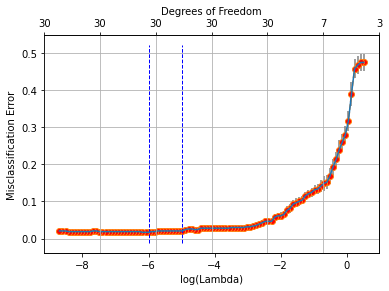

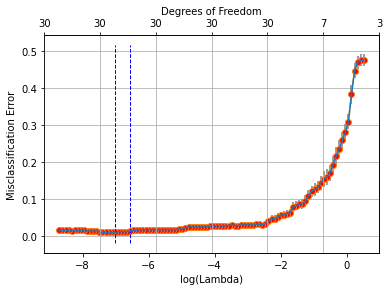

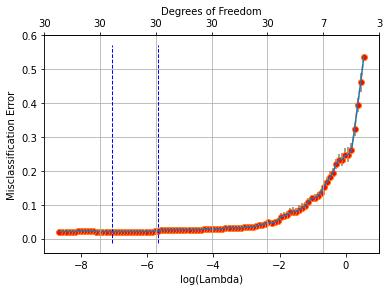

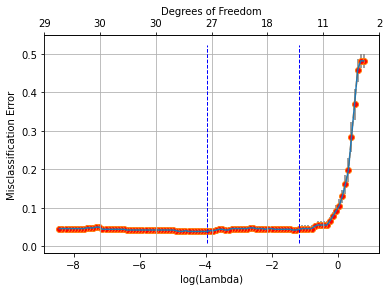

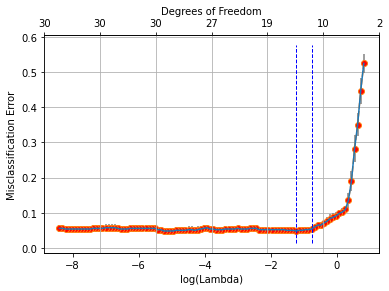

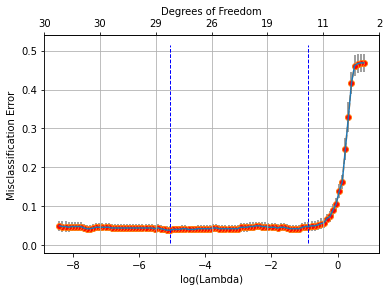

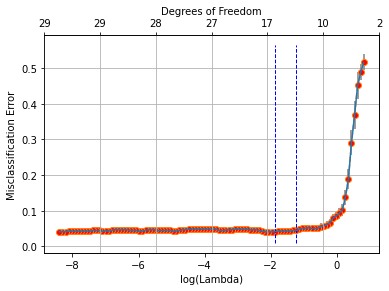

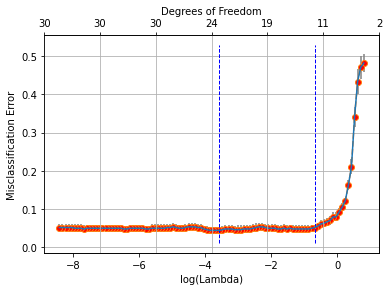

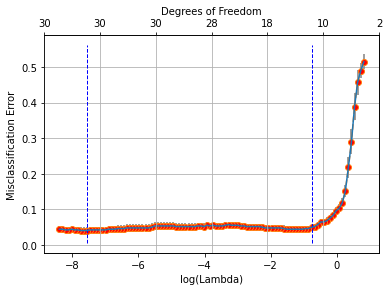

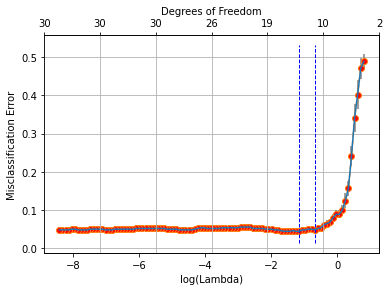

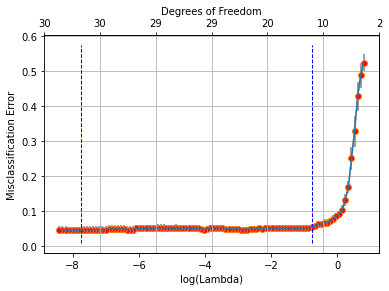

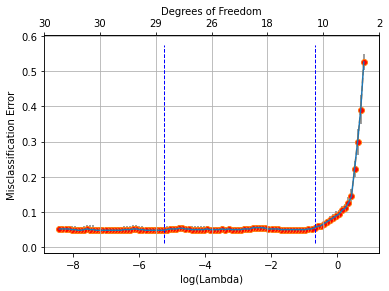

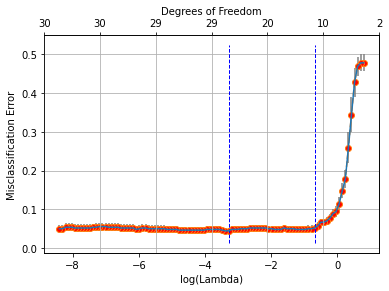

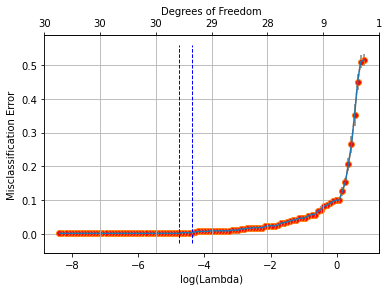

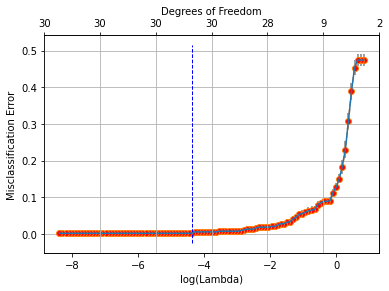

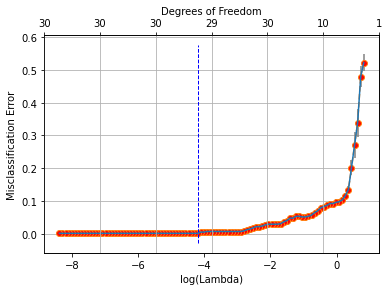

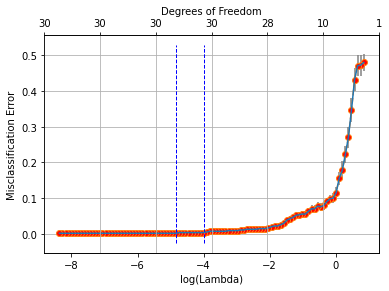

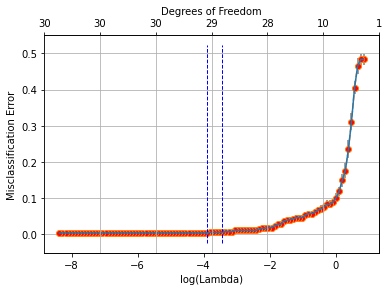

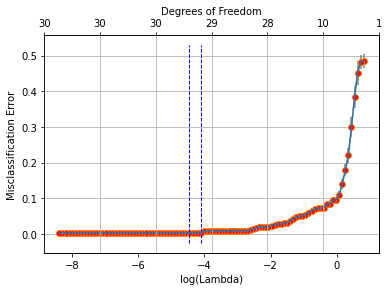

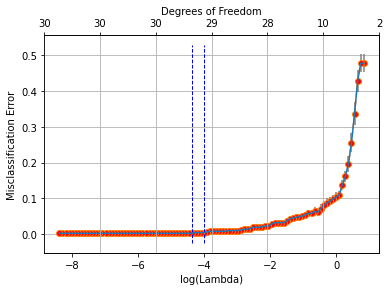

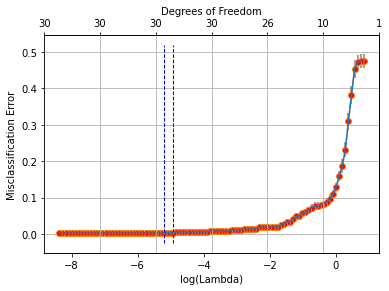

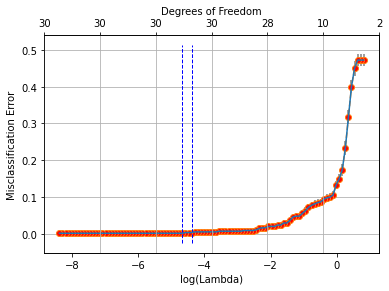

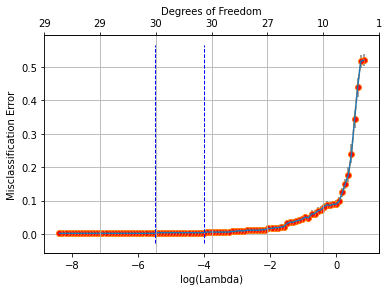

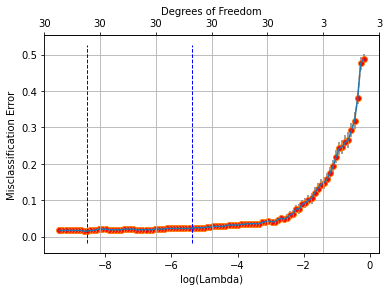

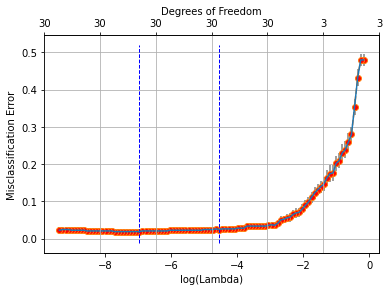

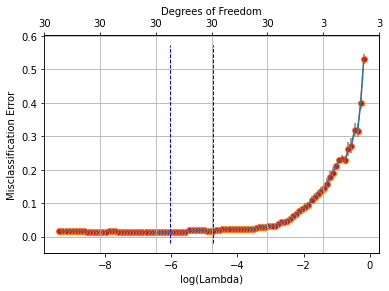

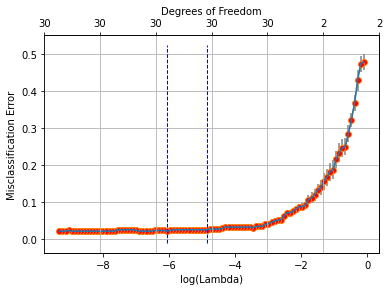

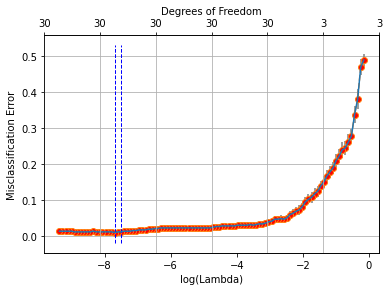

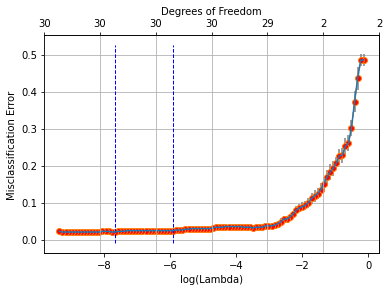

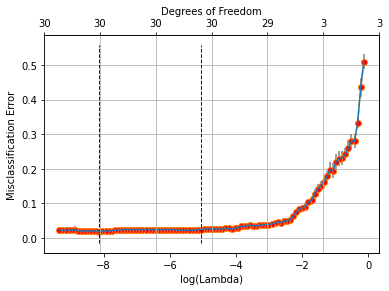

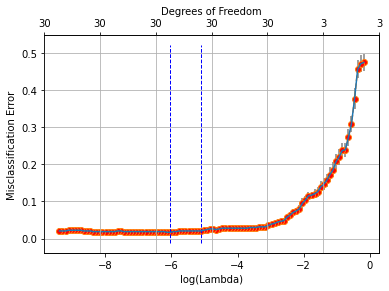

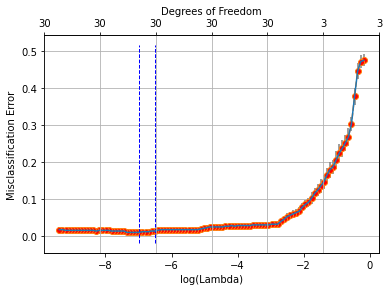

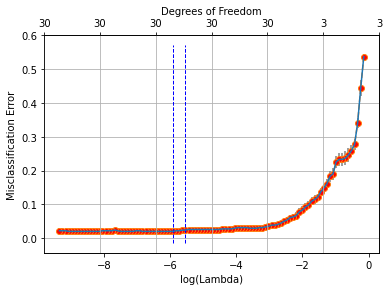

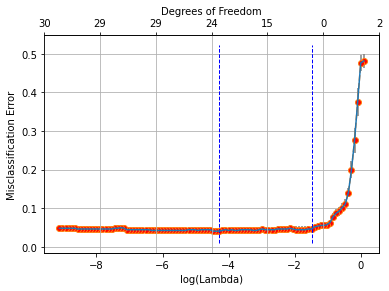

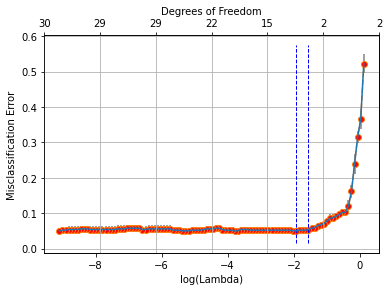

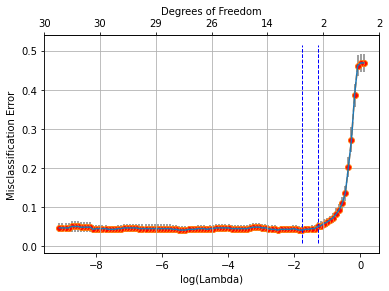

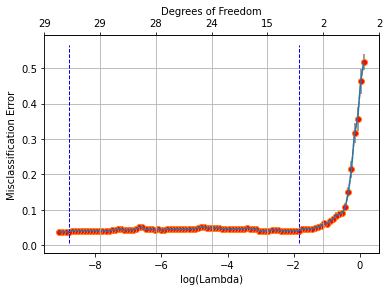

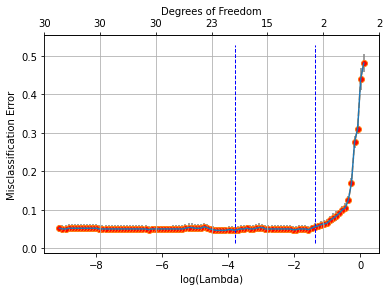

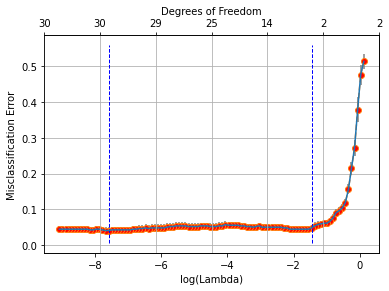

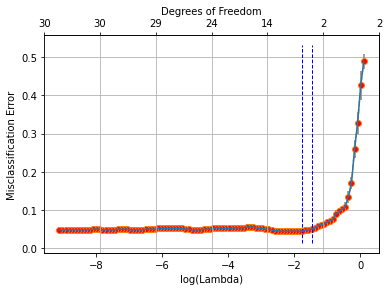

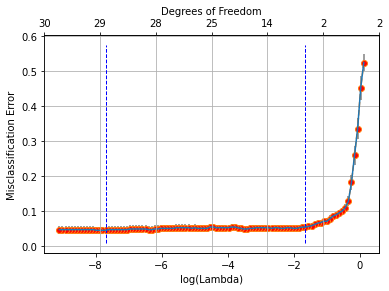

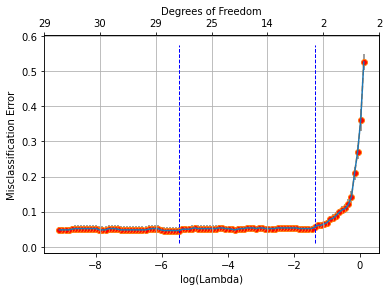

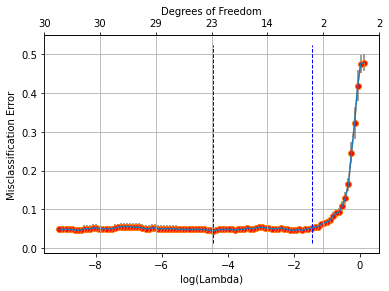

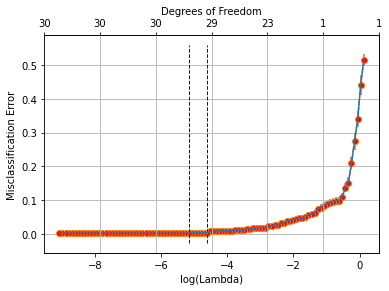

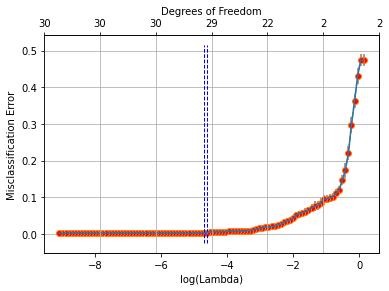

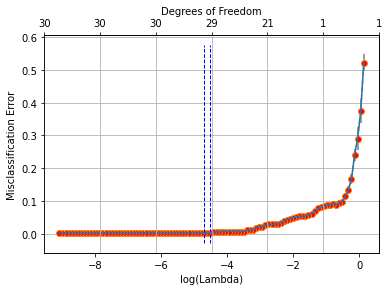

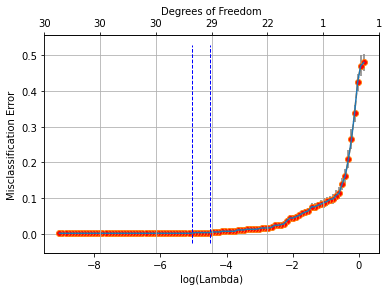

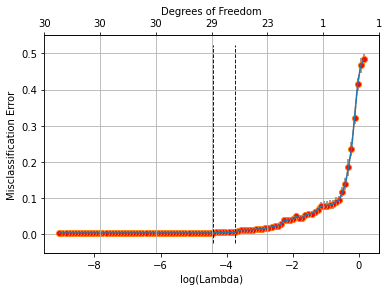

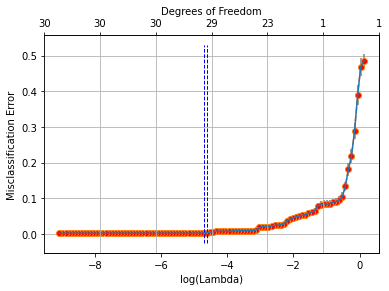

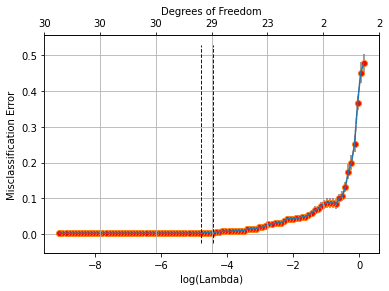

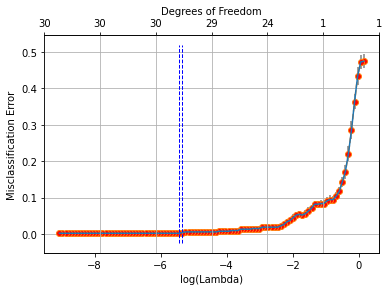

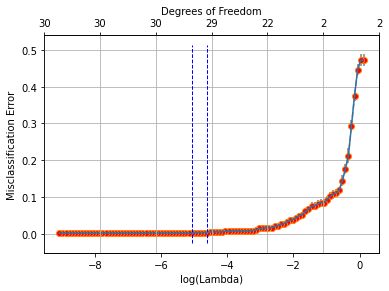

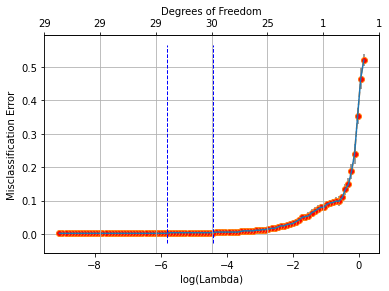

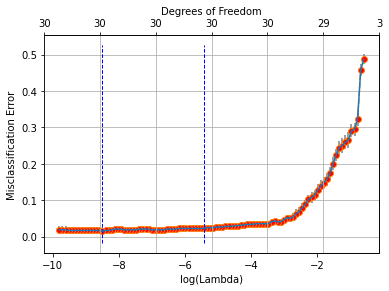

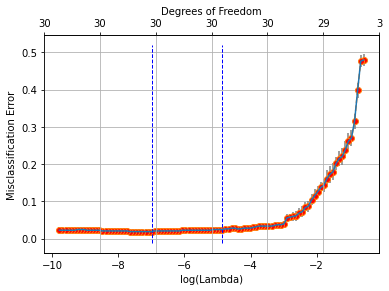

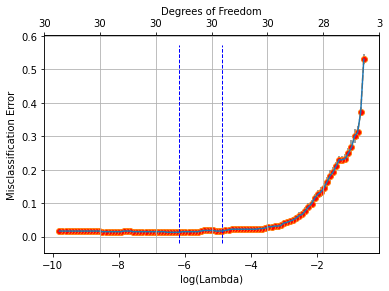

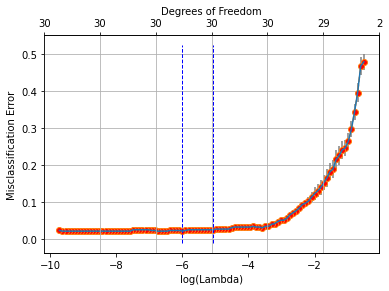

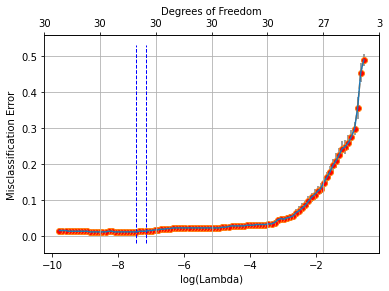

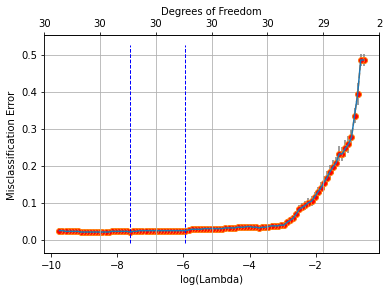

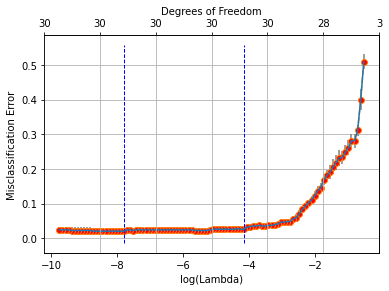

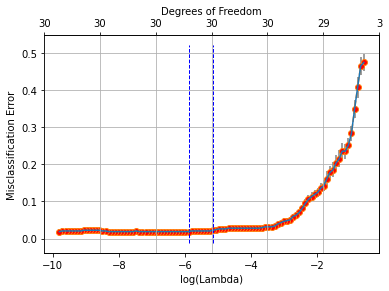

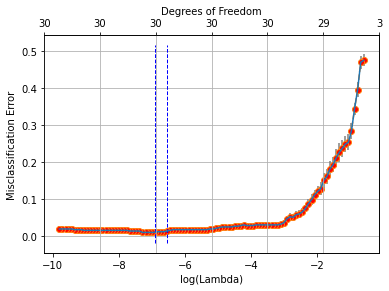

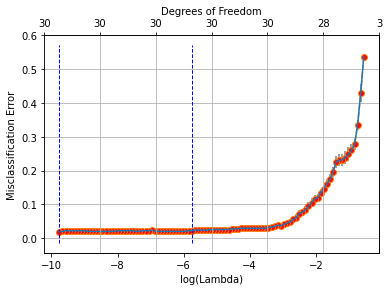

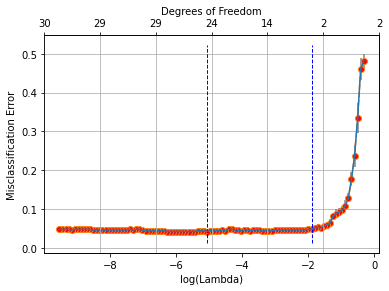

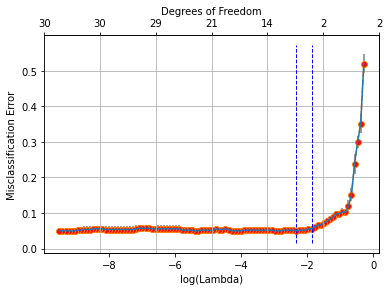

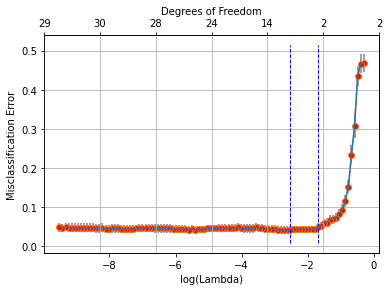

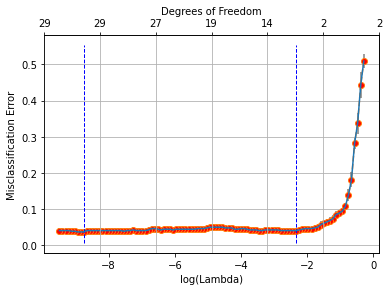

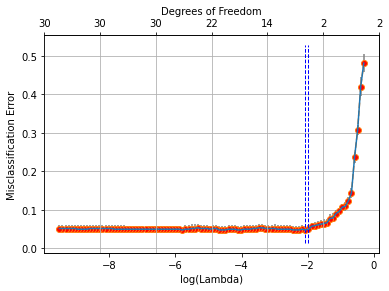

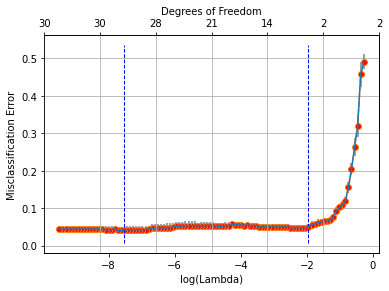

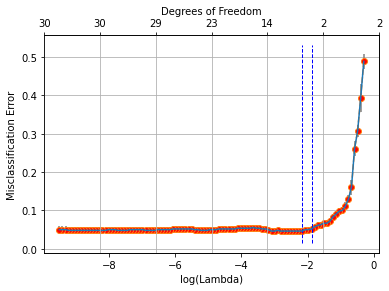

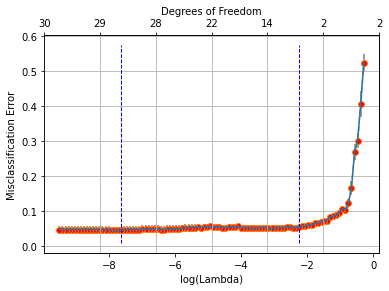

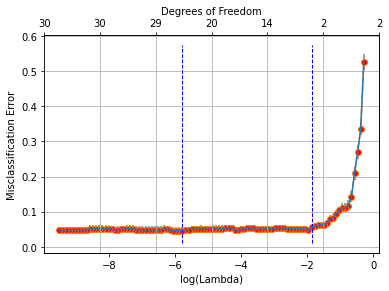

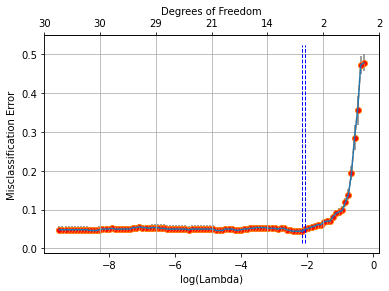

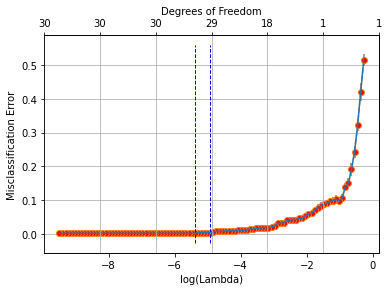

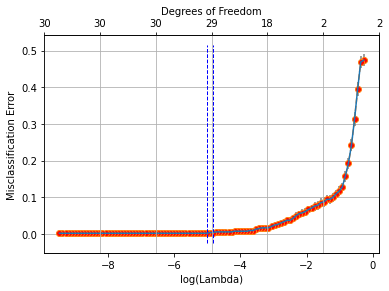

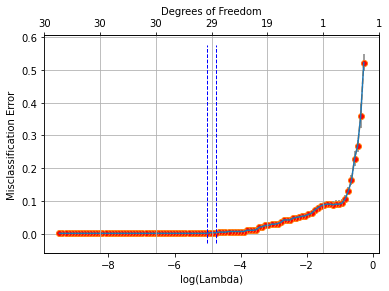

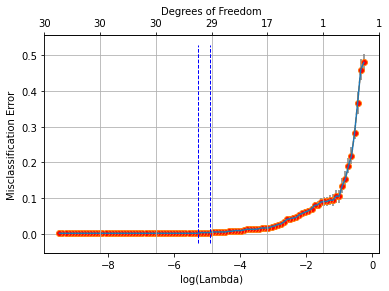

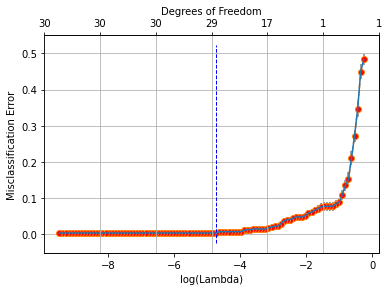

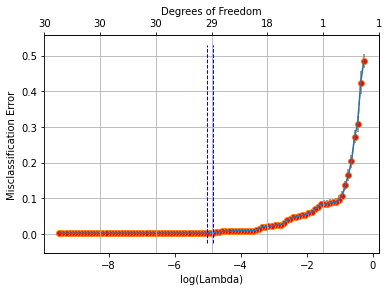

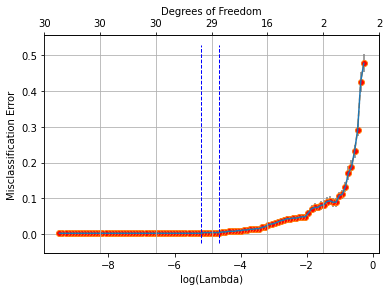

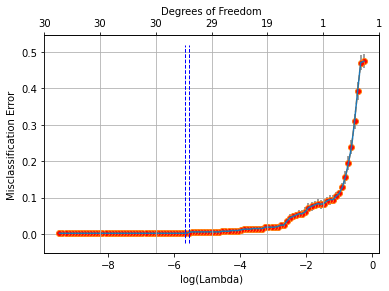

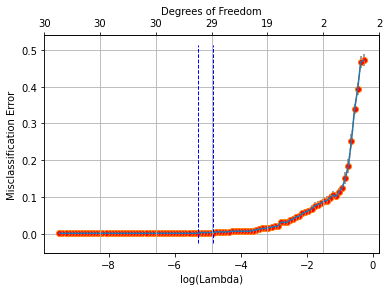

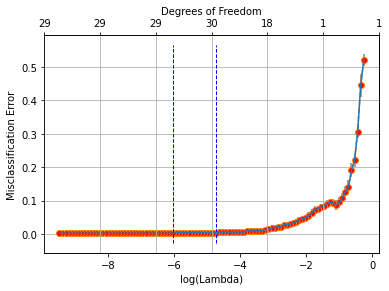

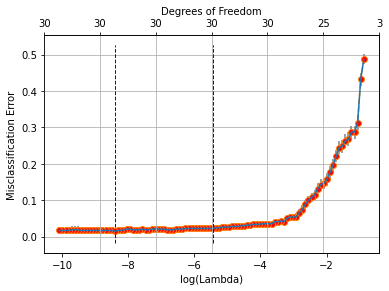

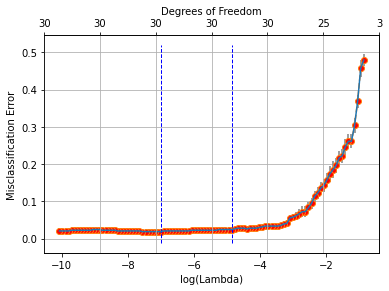

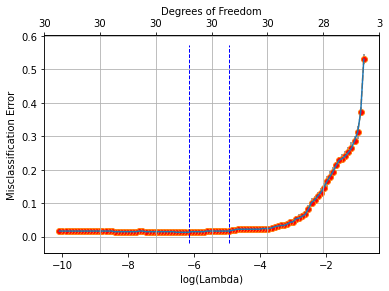

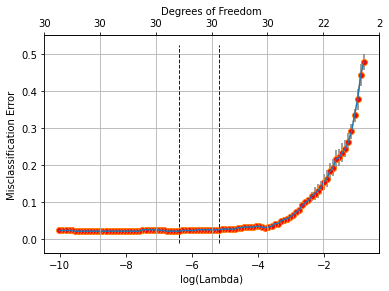

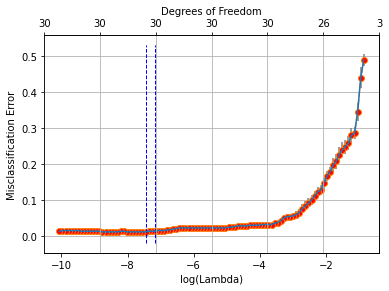

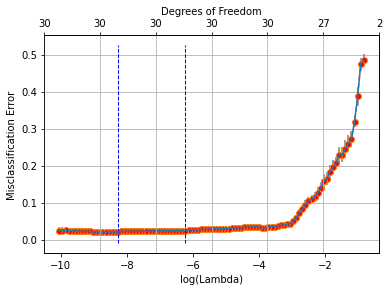

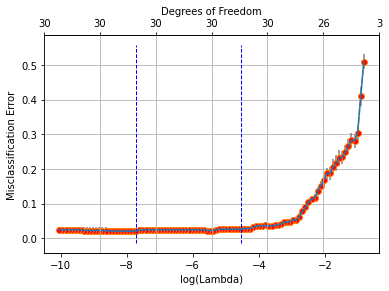

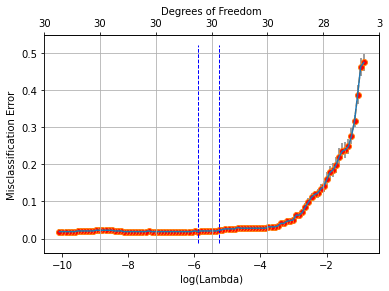

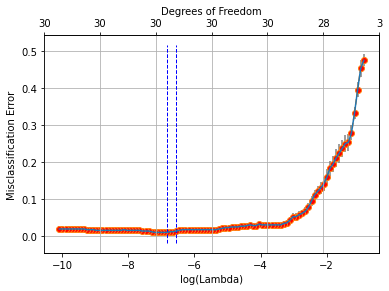

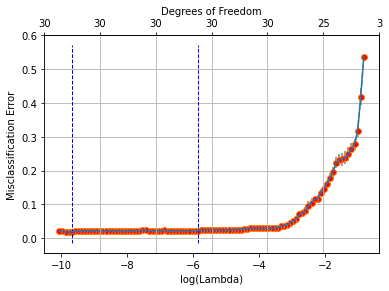

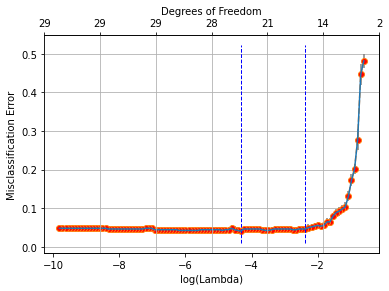

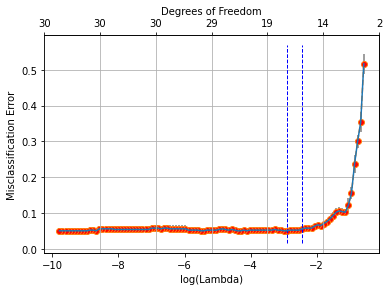

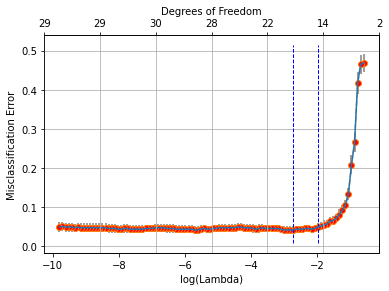

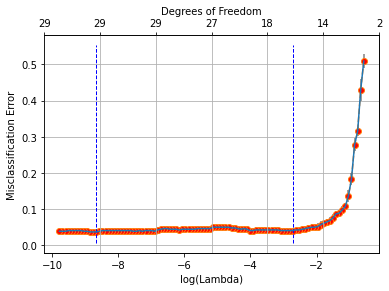

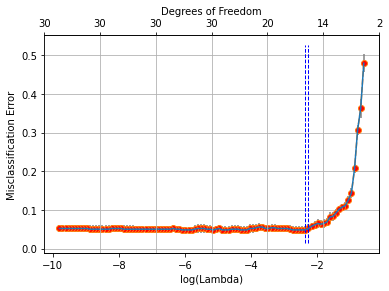

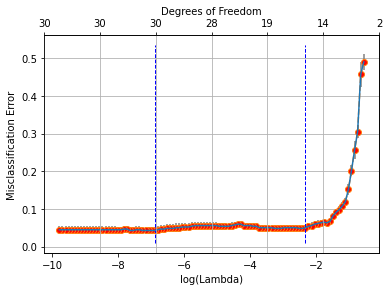

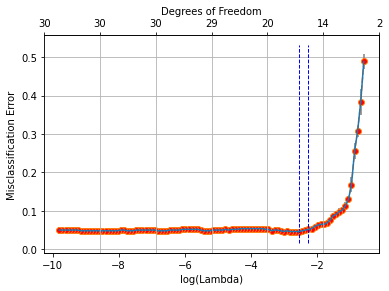

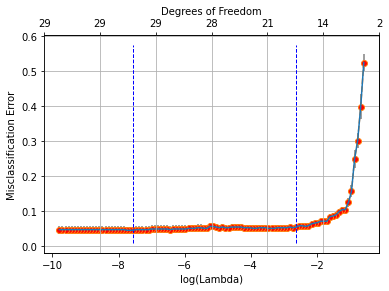

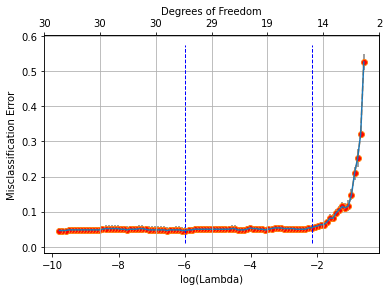

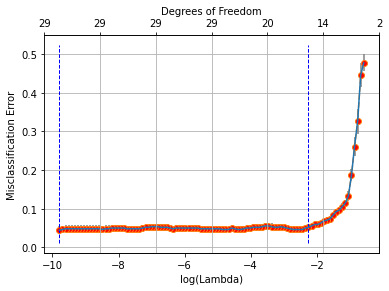

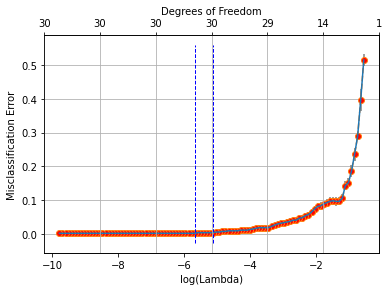

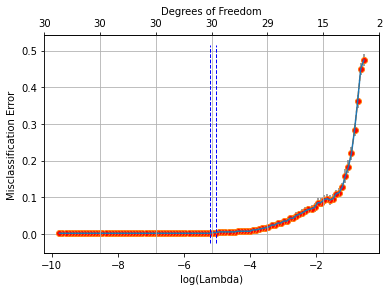

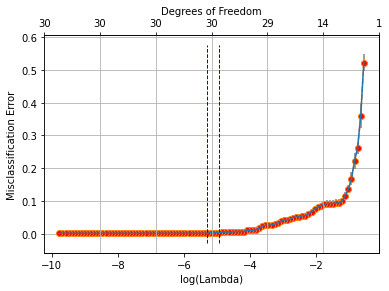

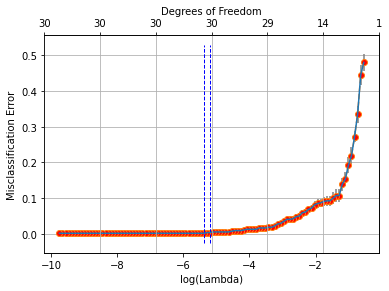

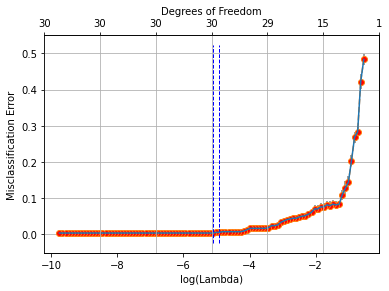

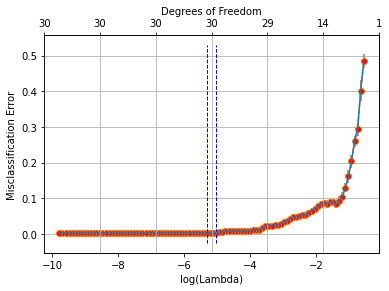

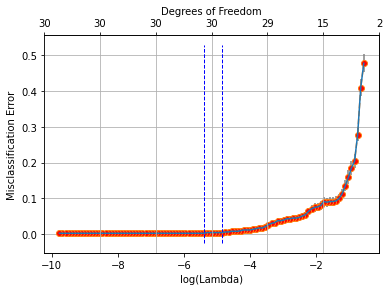

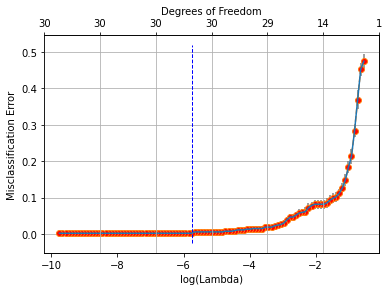

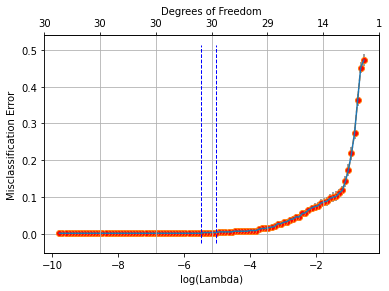

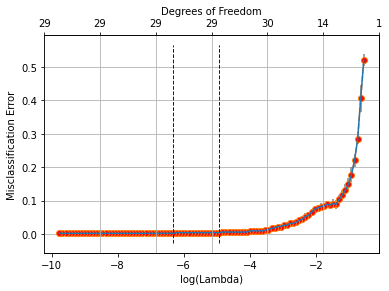

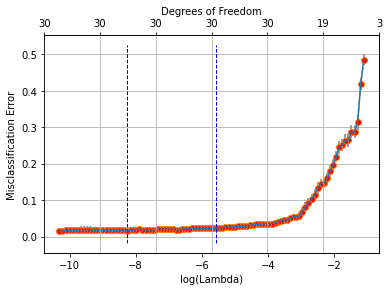

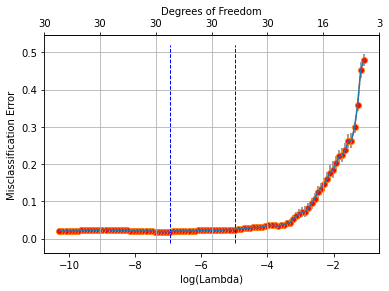

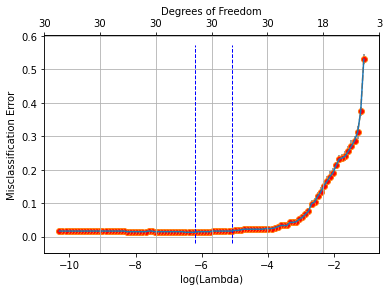

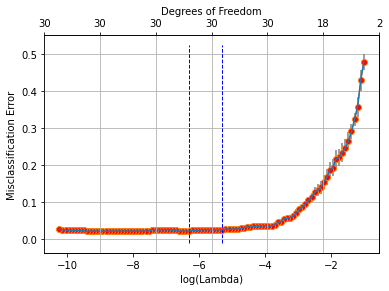

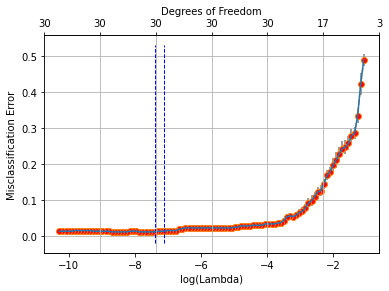

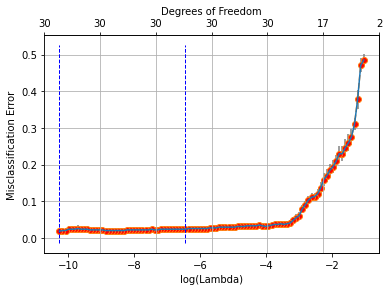

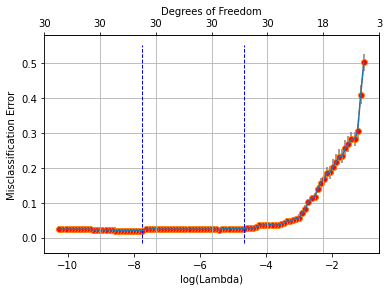

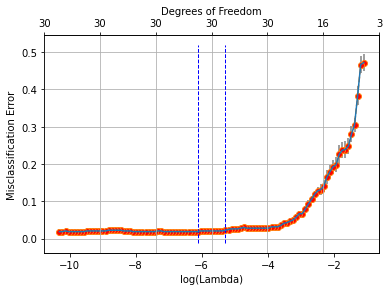

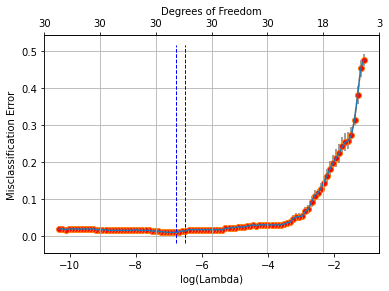

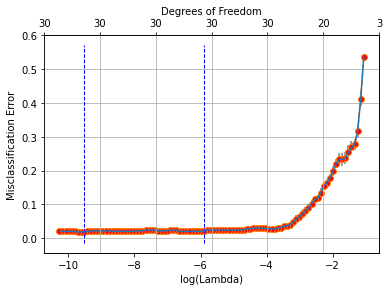

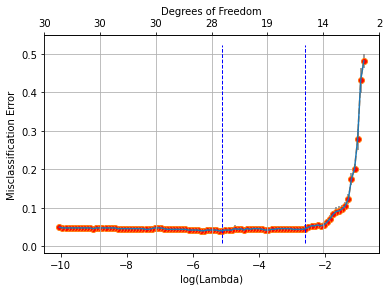

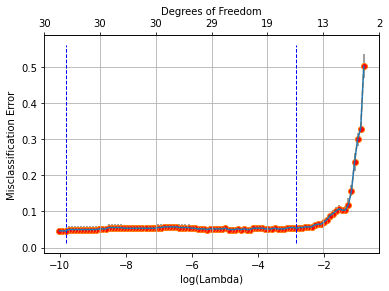

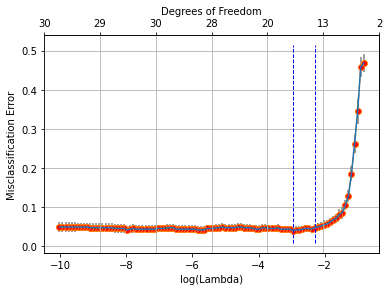

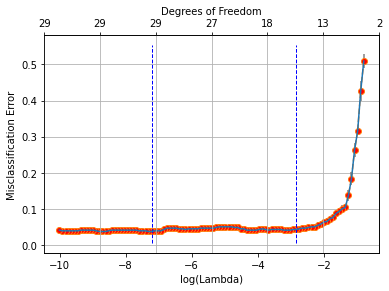

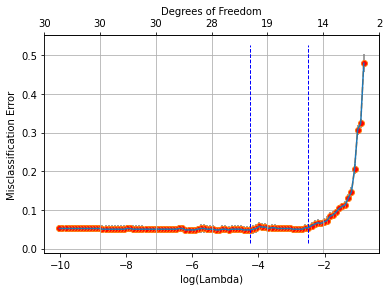

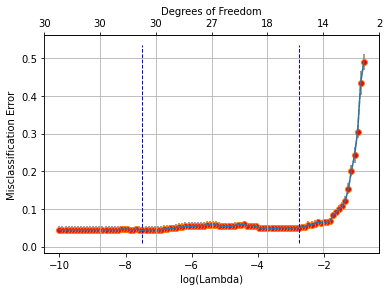

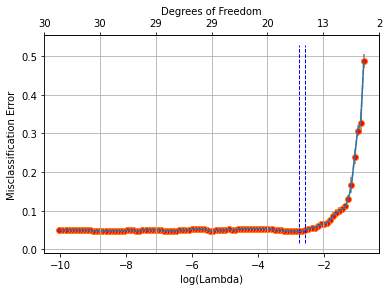

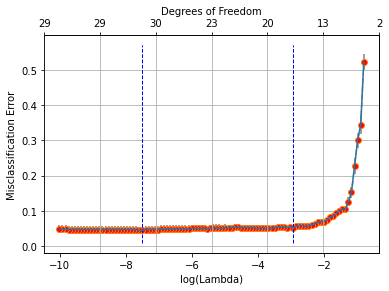

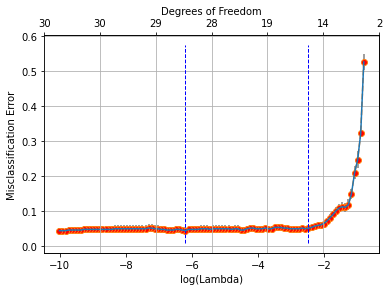

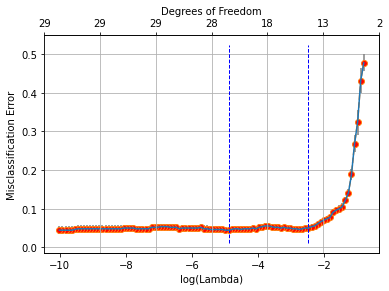

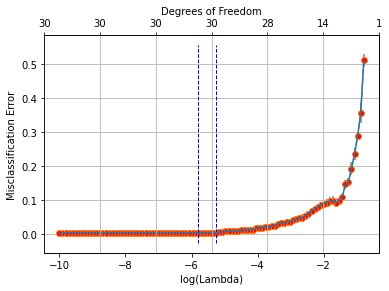

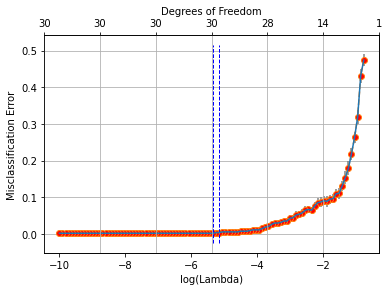

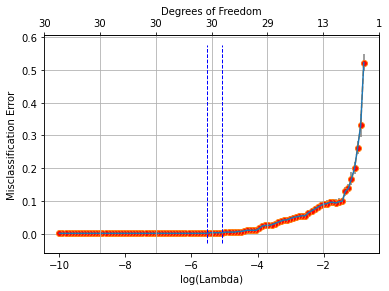

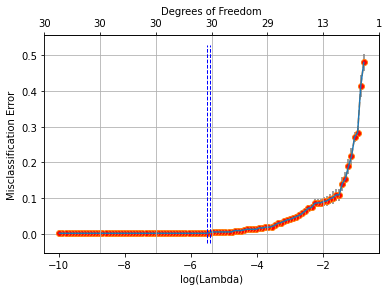

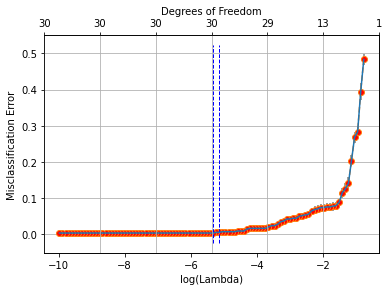

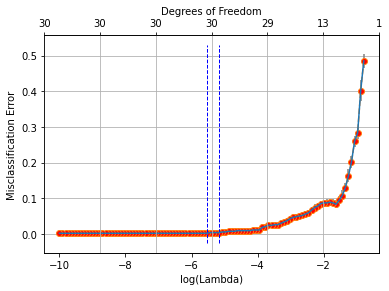

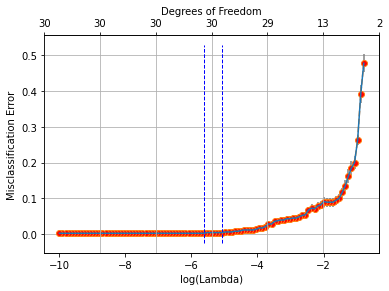

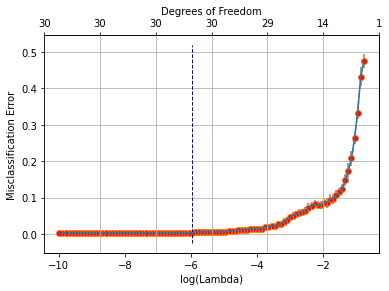

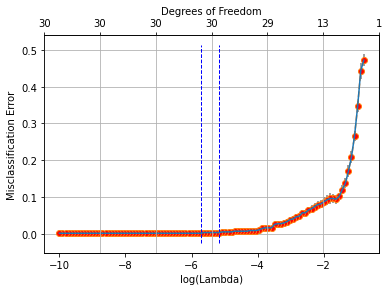

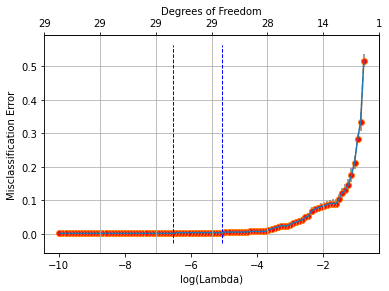

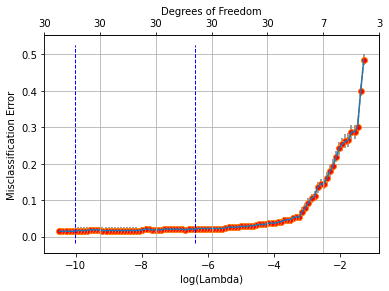

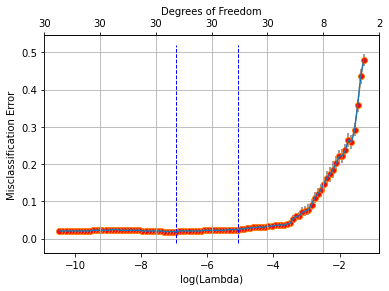

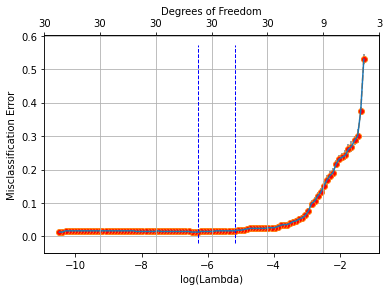

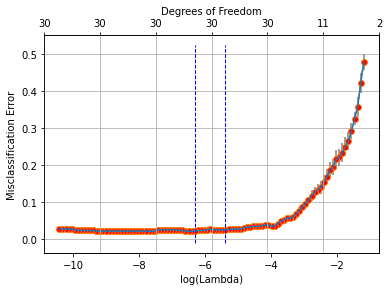

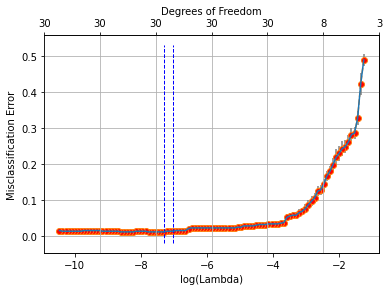

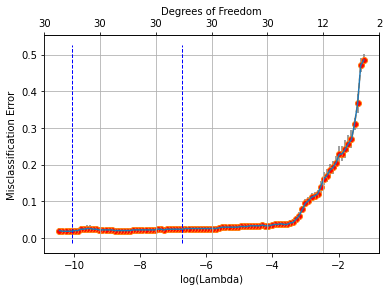

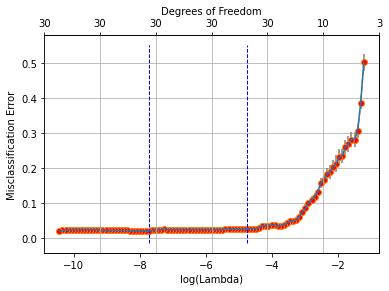

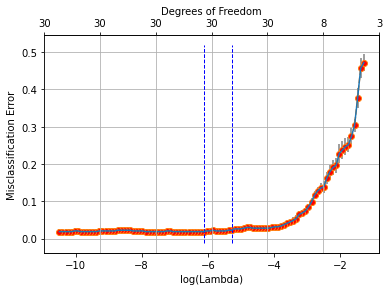

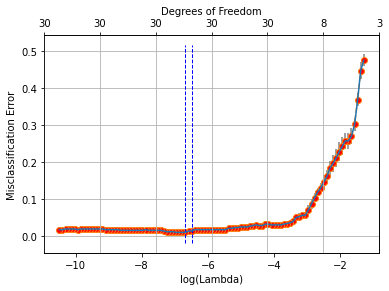

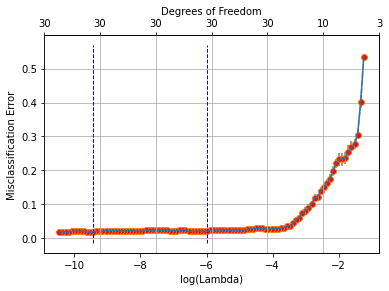

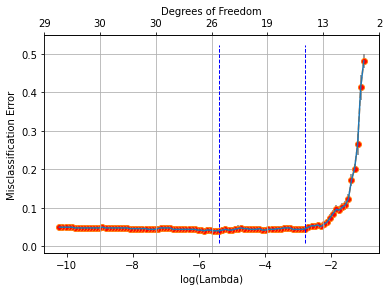

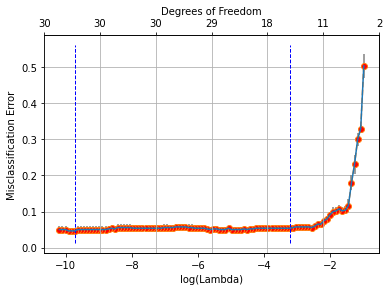

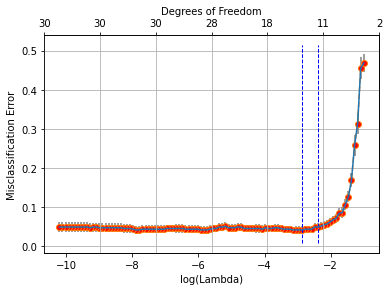

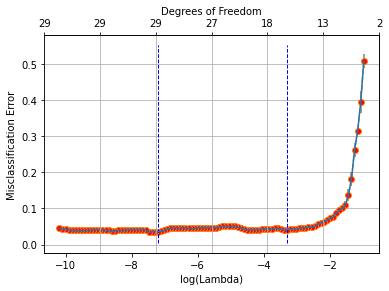

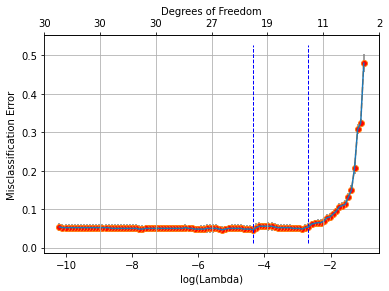

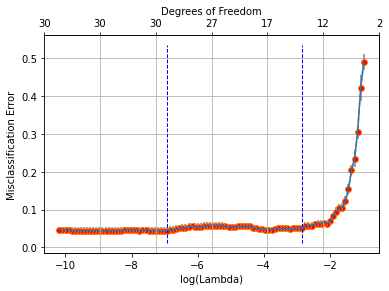

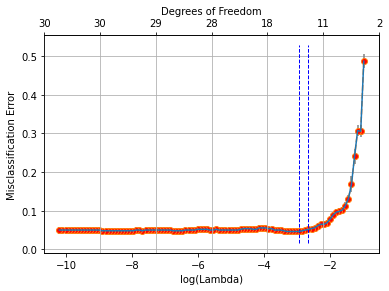

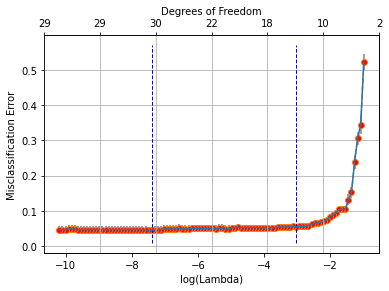

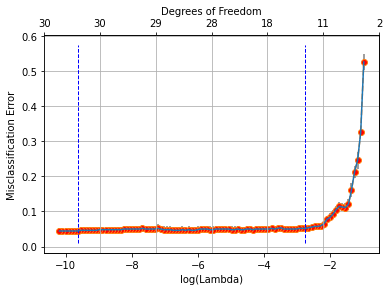

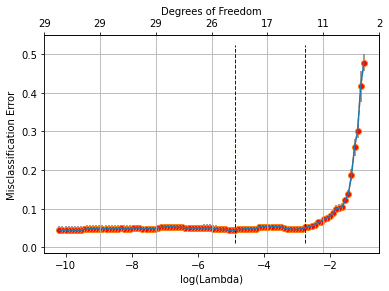

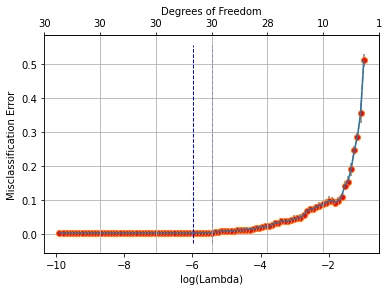

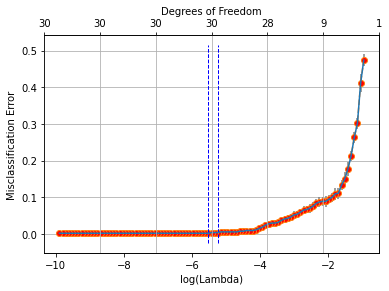

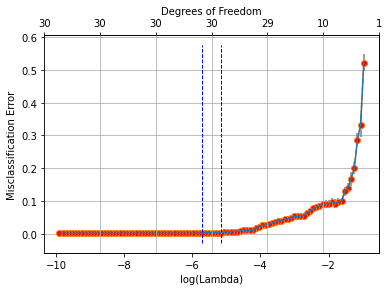

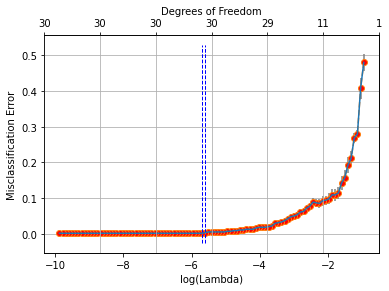

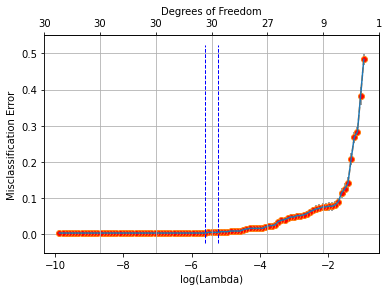

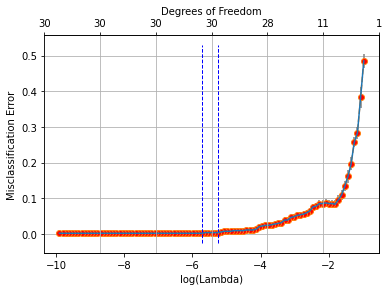

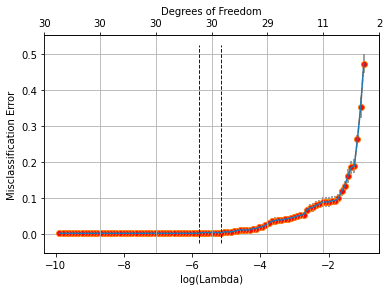

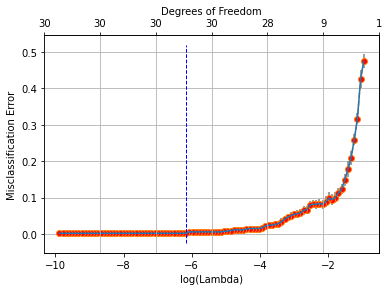

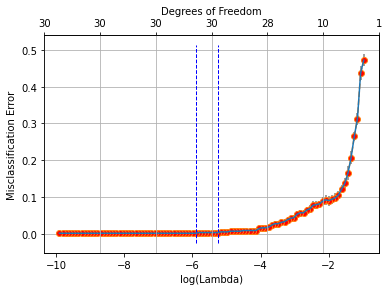

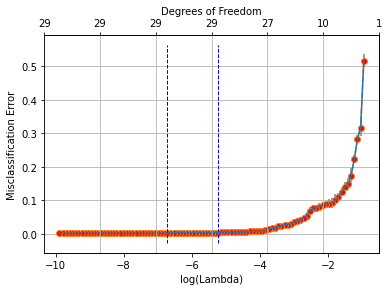

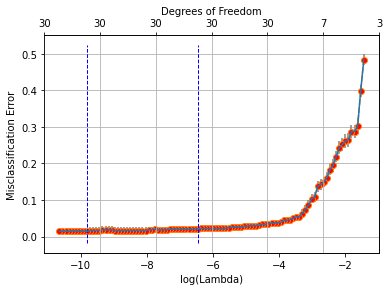

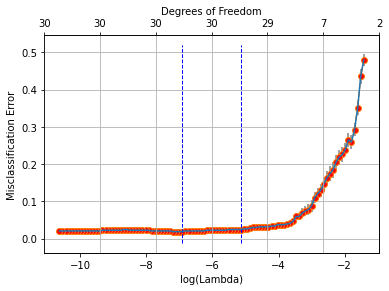

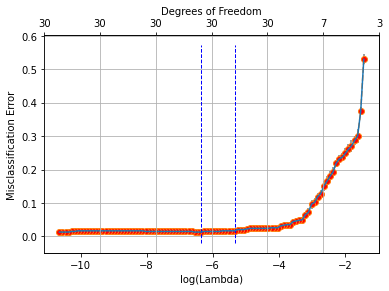

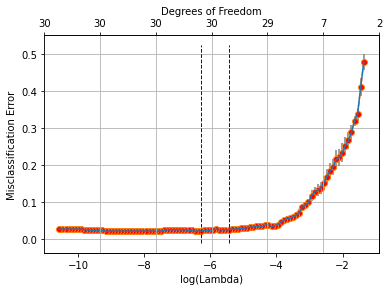

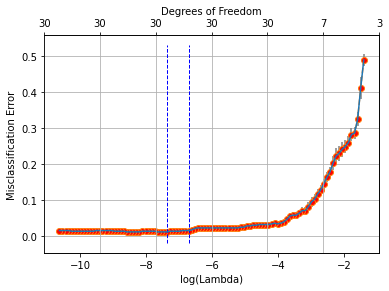

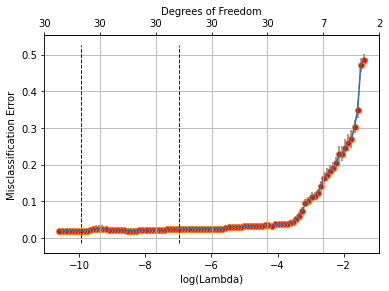

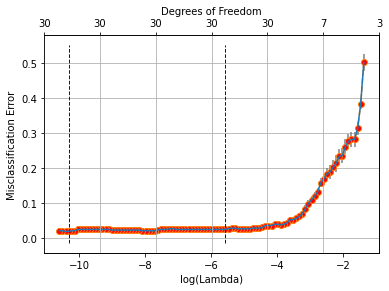

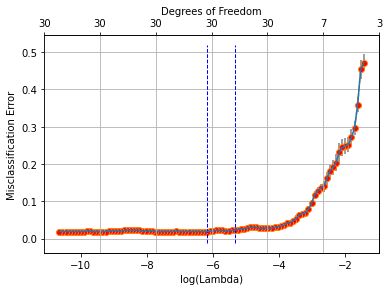

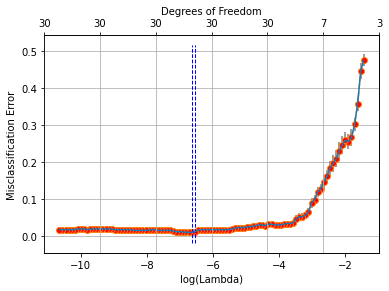

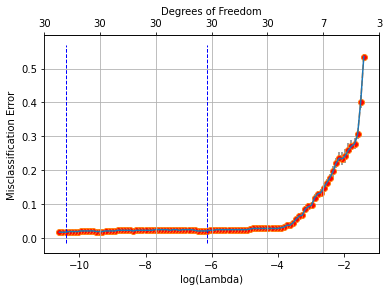

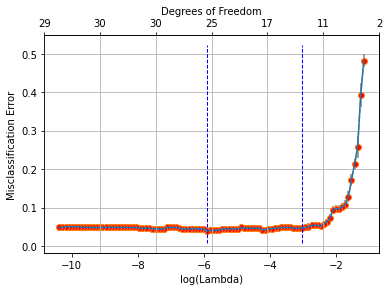

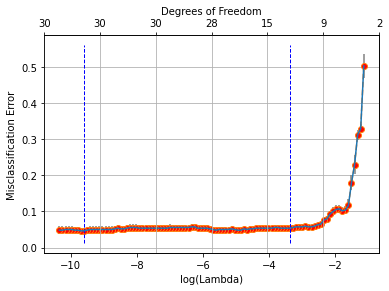

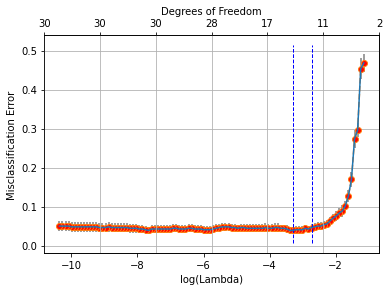

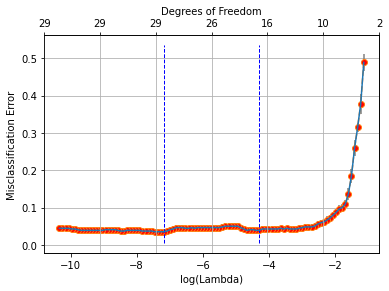

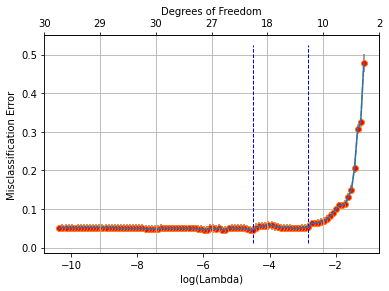

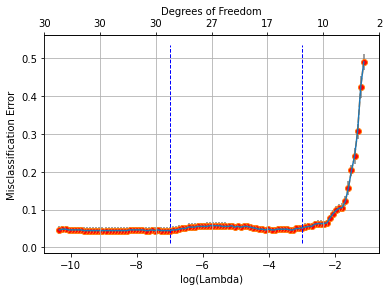

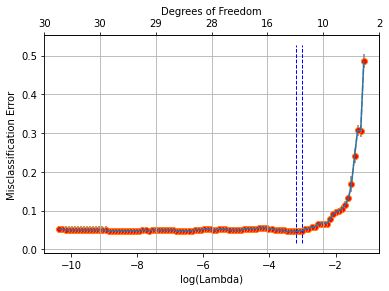

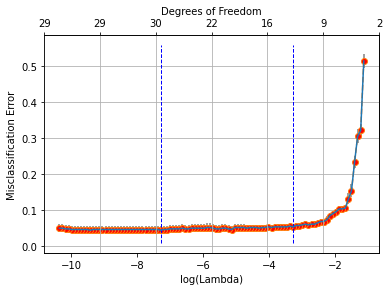

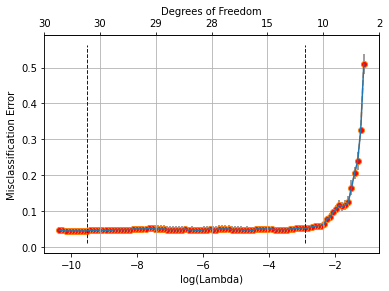

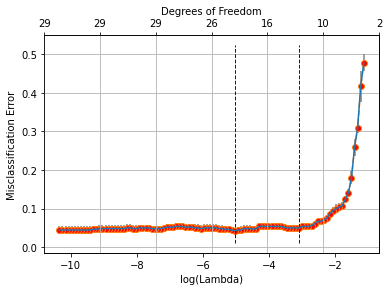

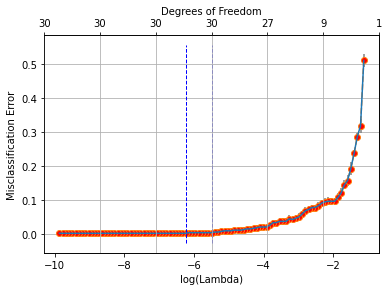

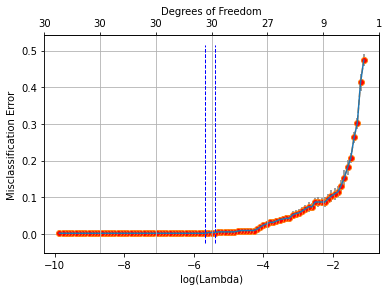

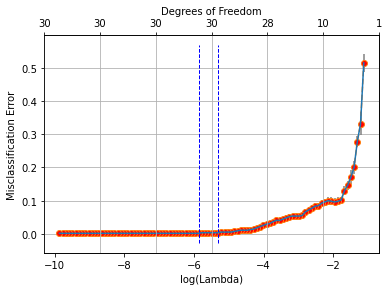

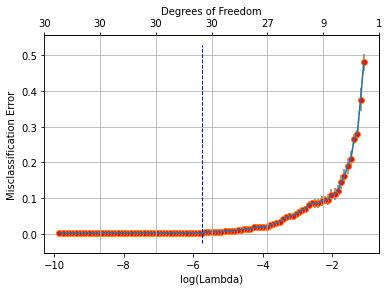

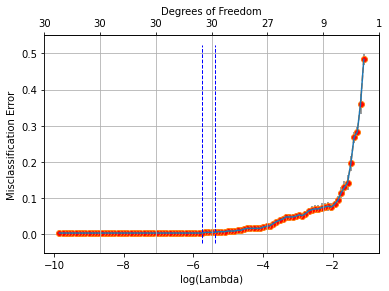

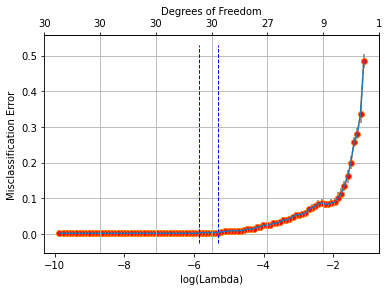

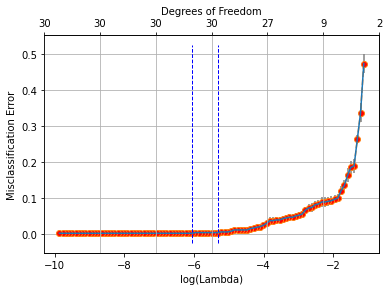

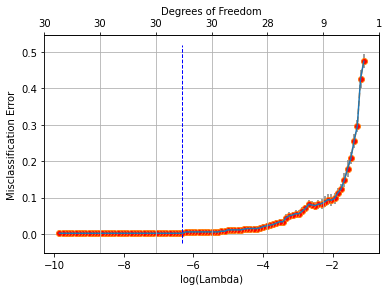

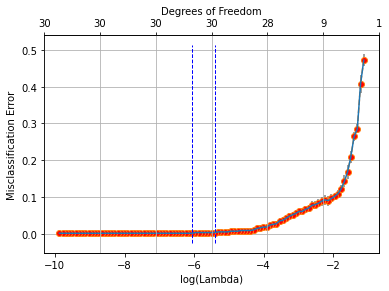

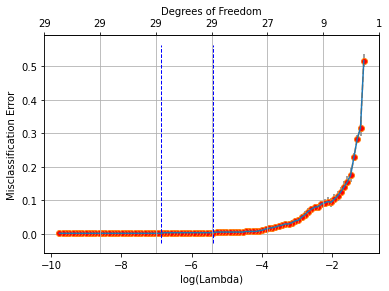

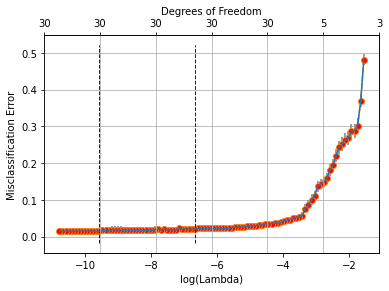

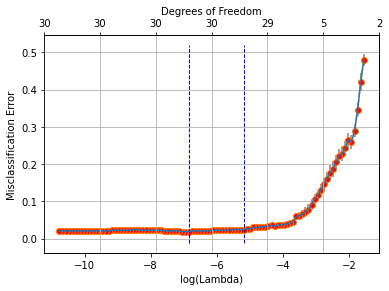

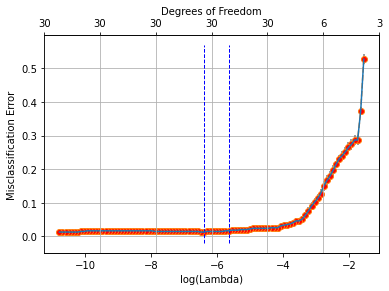

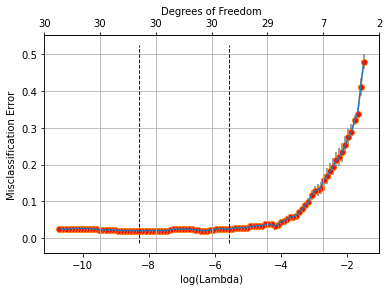

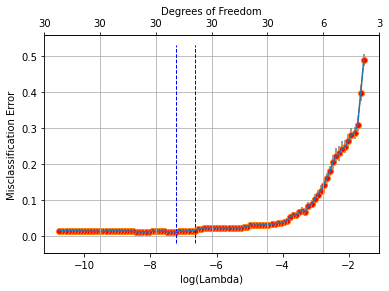

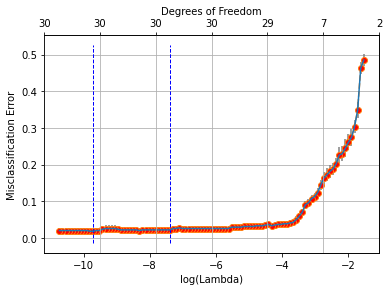

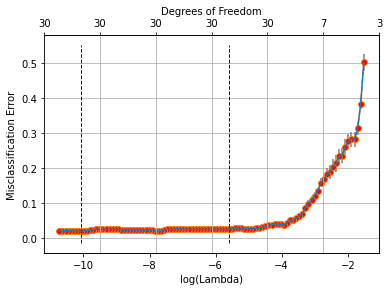

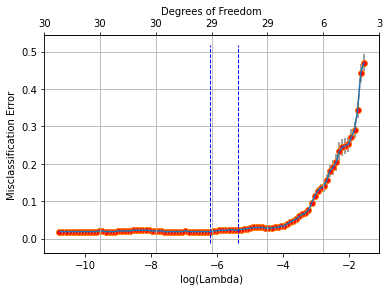

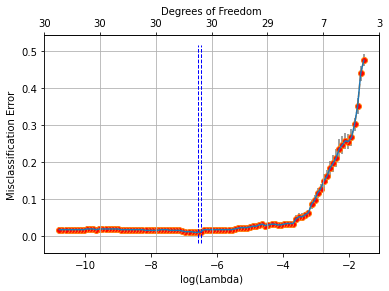

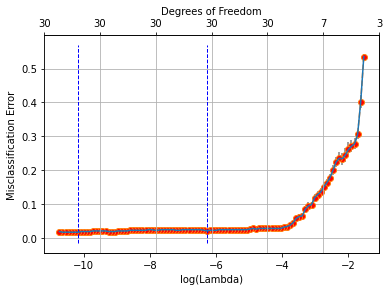

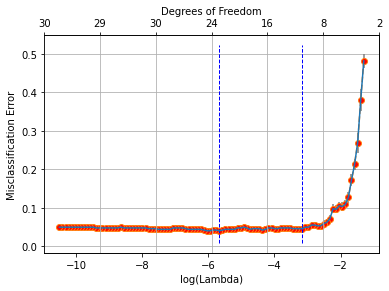

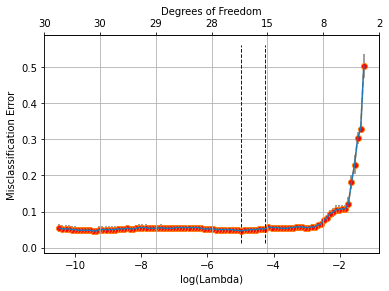

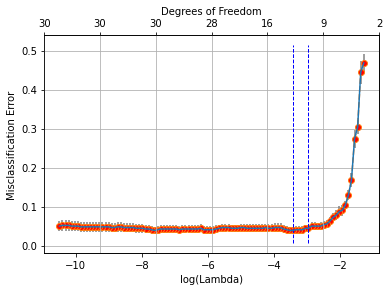

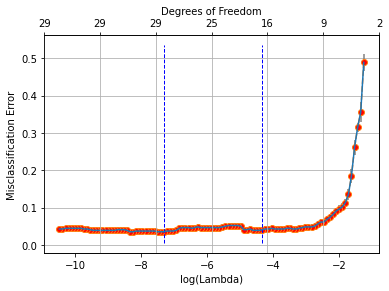

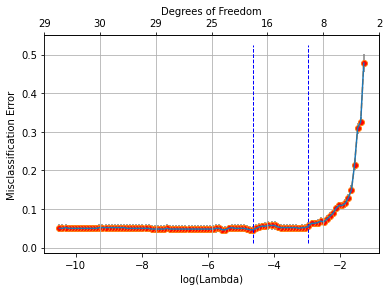

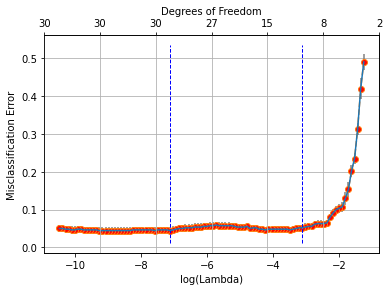

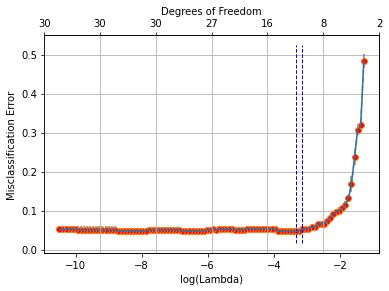

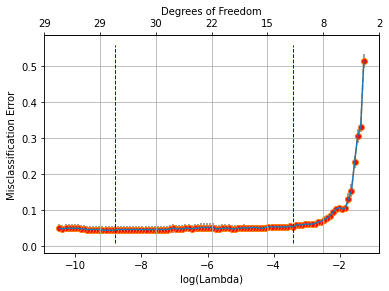

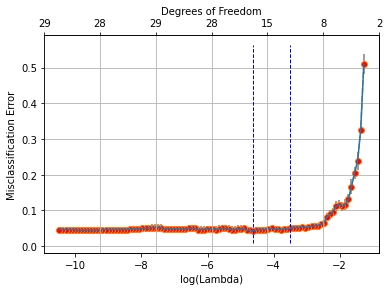

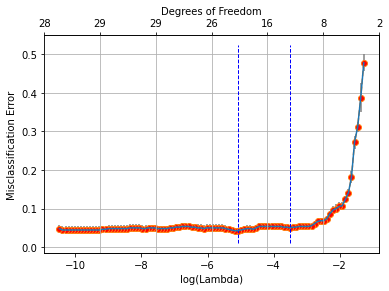

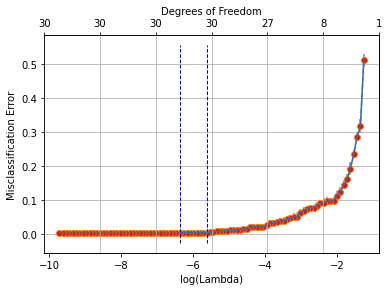

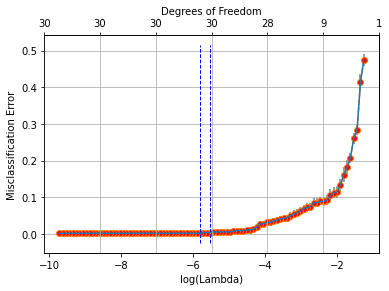

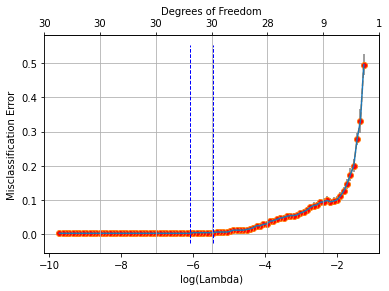

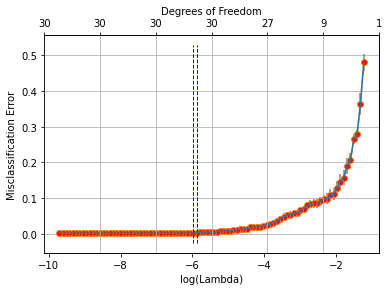

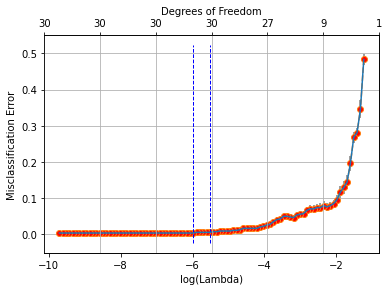

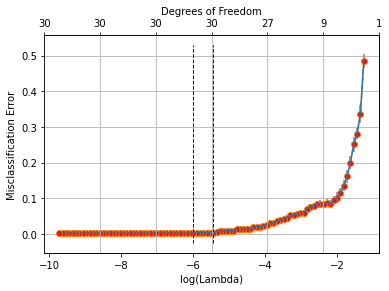

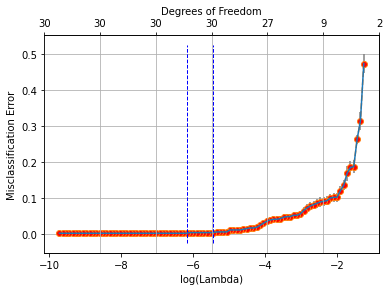

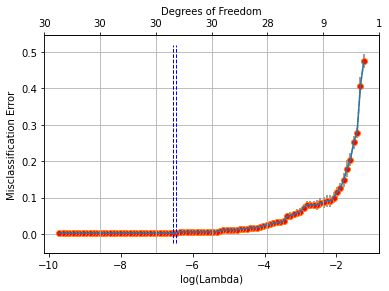

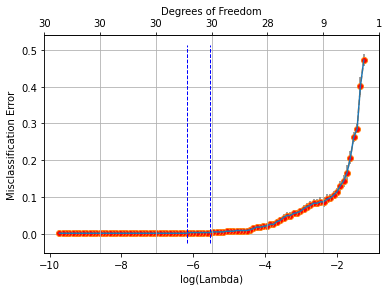

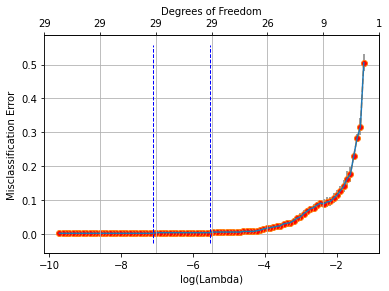

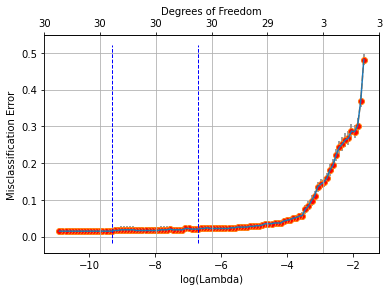

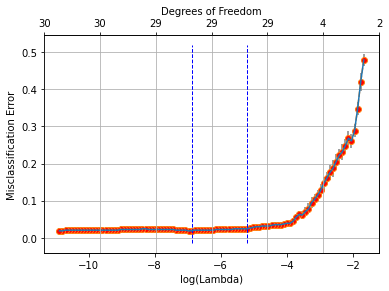

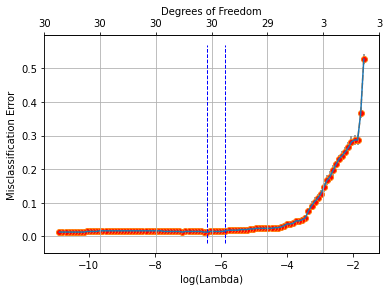

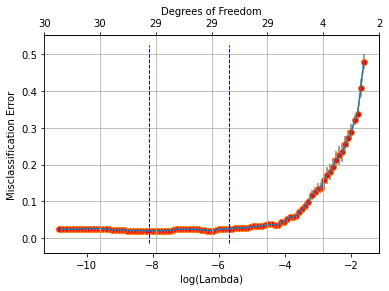

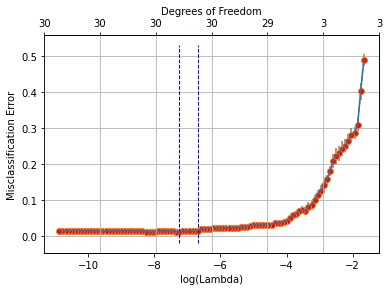

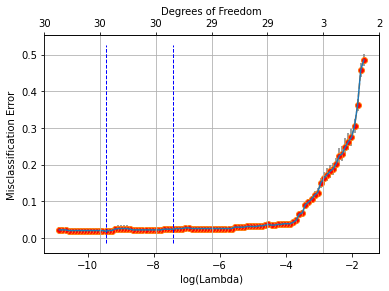

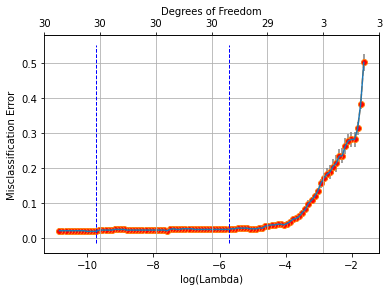

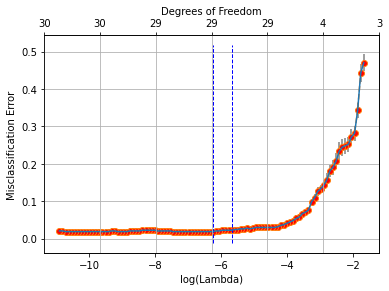

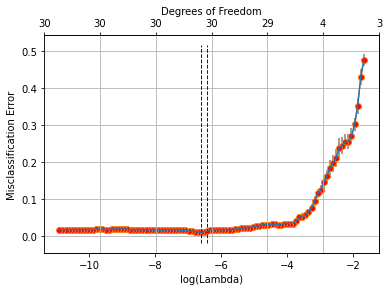

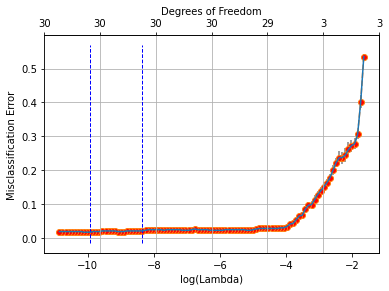

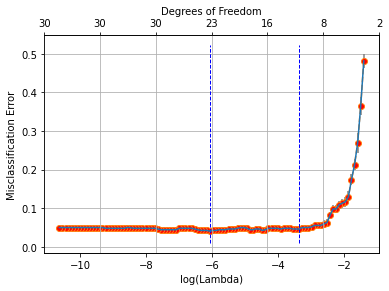

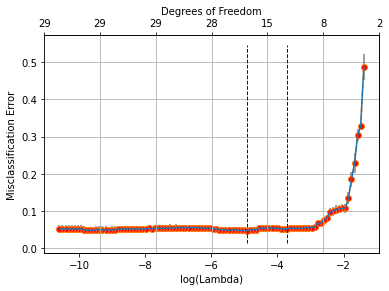

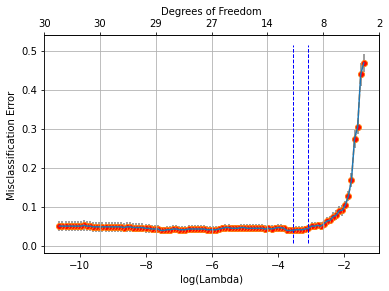

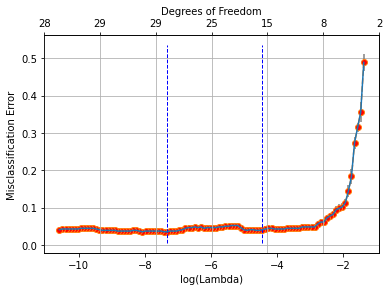

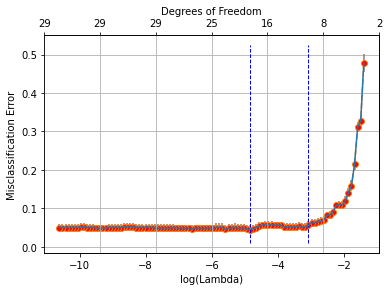

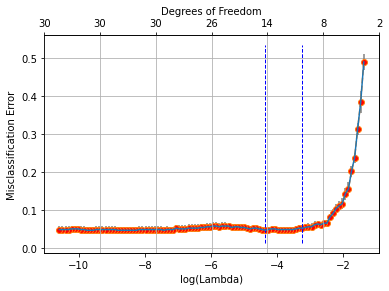

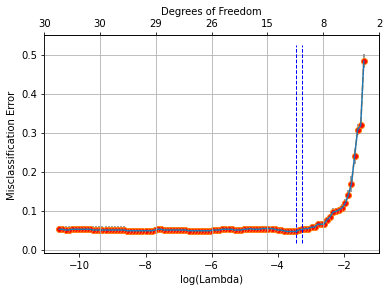

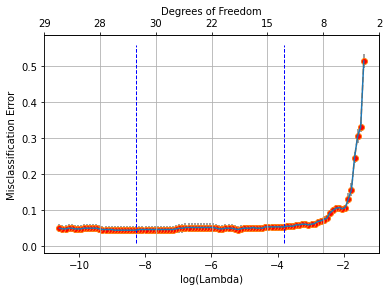

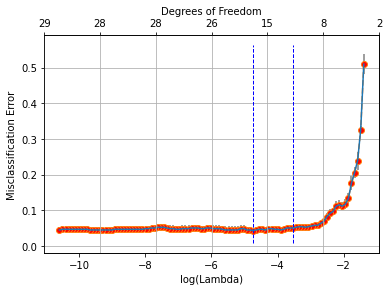

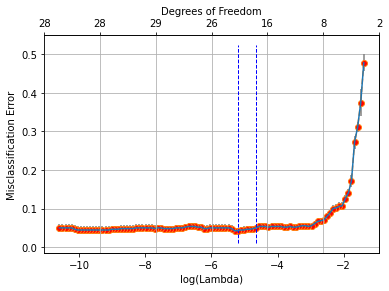

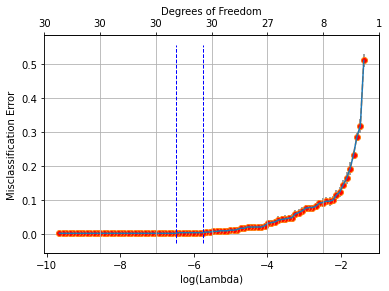

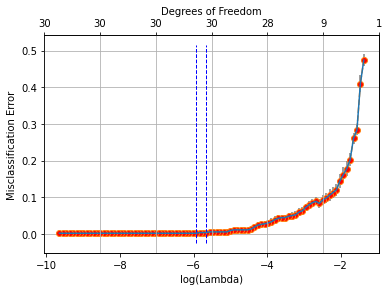

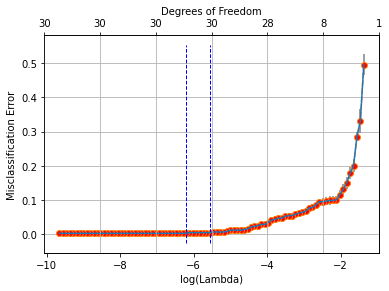

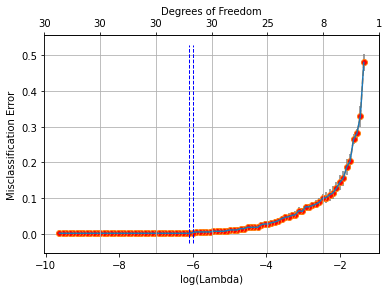

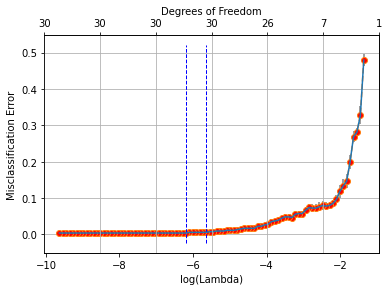

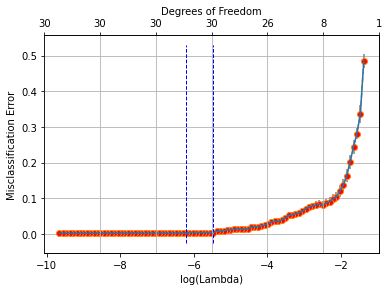

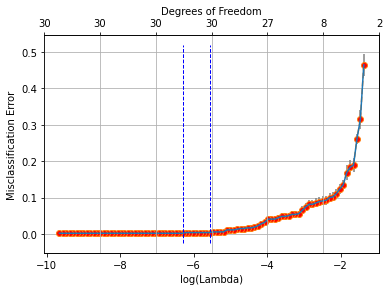

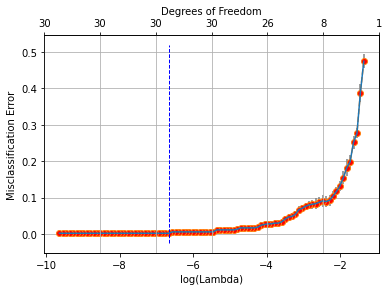

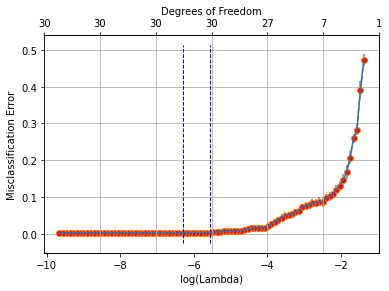

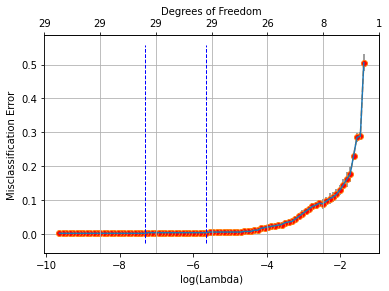

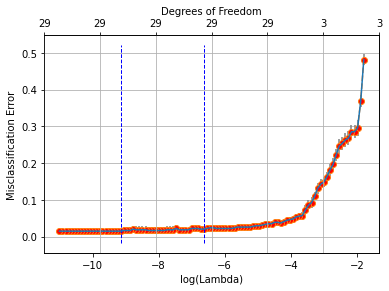

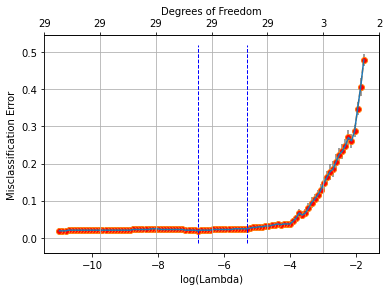

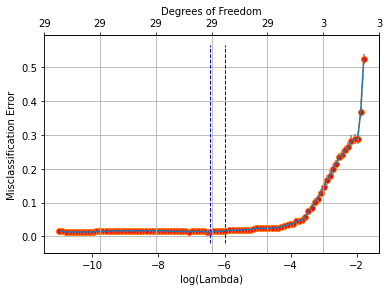

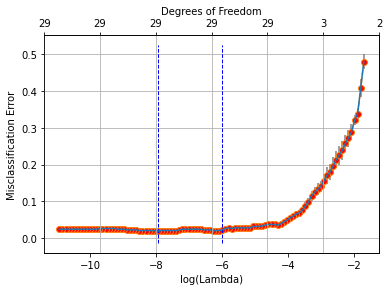

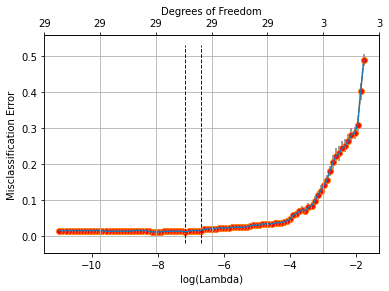

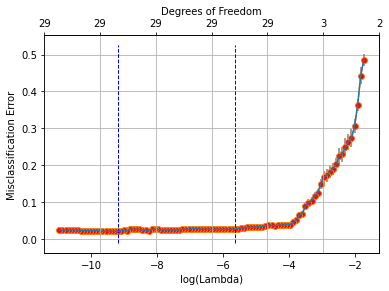

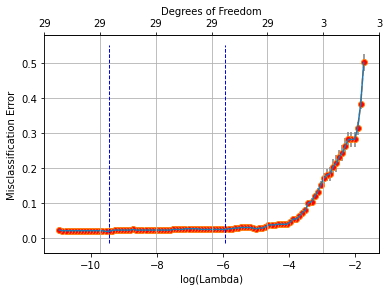

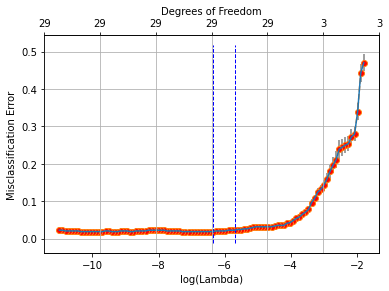

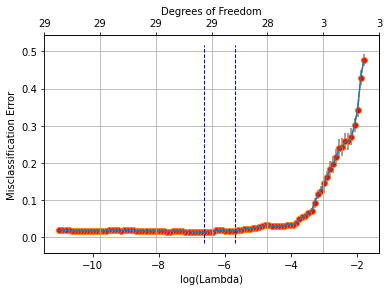

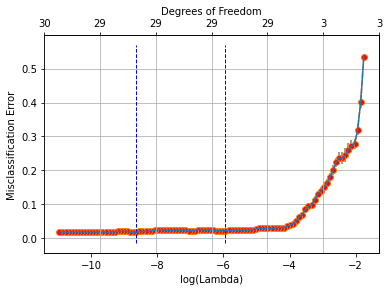

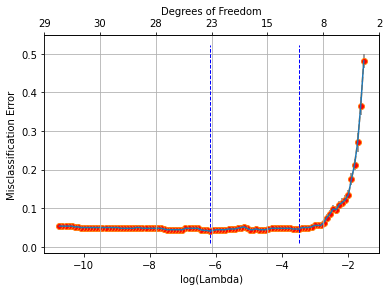

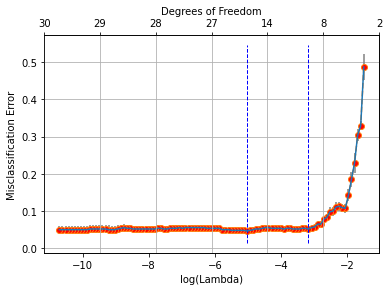

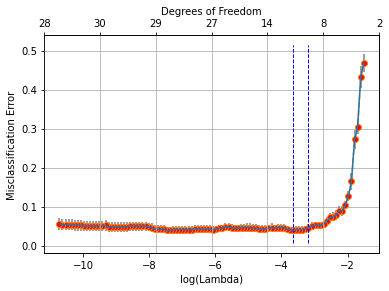

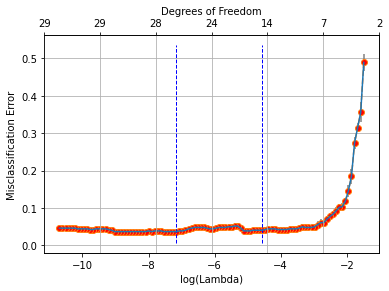

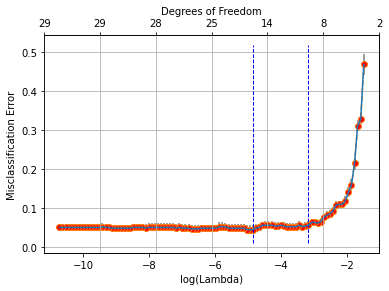

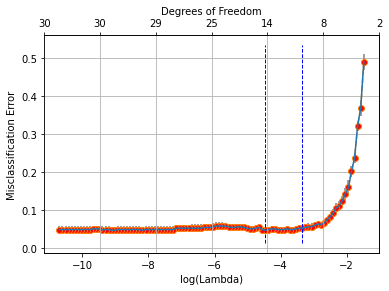

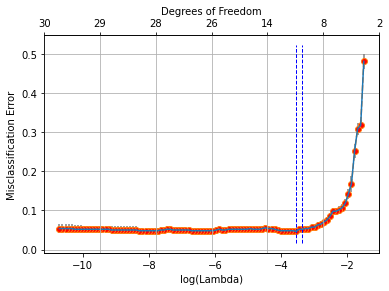

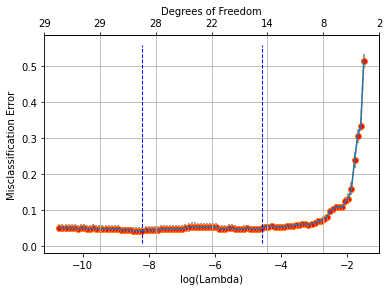

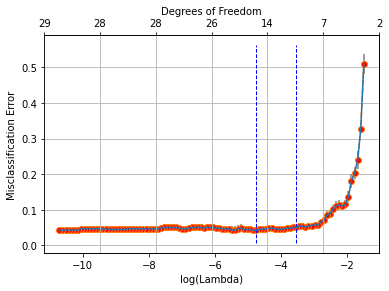

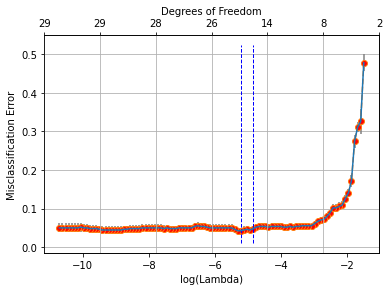

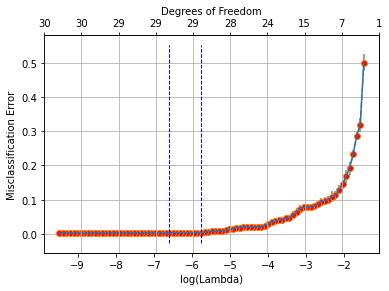

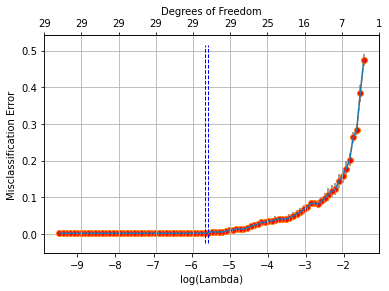

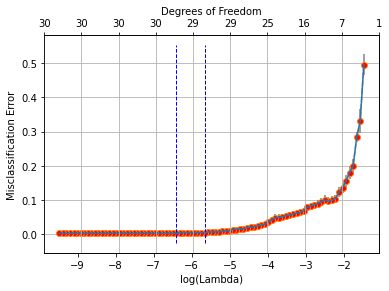

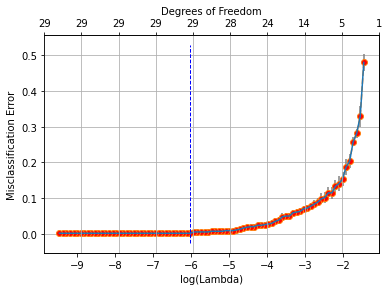

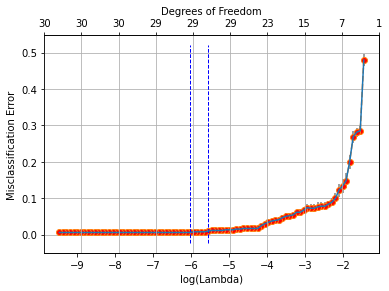

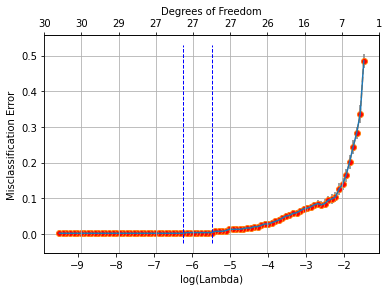

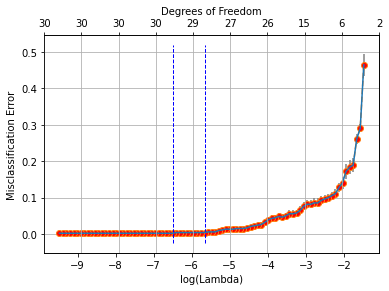

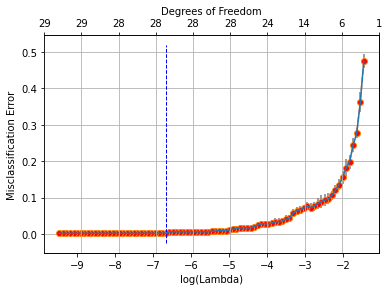

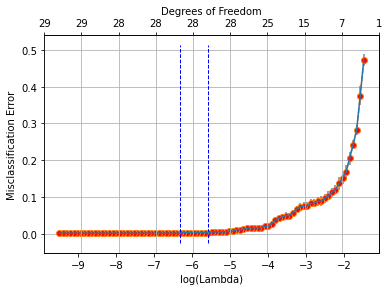

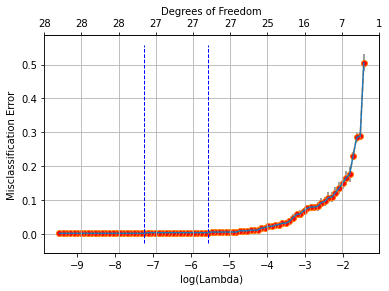

In [12]:
"""
Comparing all three strategies for ideal subjects
"""
GLMscore_mean = np.zeros((11,1))
PyGLMscore_mean = np.zeros((11,1))
GLMscore_sigMean = np.zeros((11,1))
PyGLMscore_sigMean = np.zeros((11,1))
GLMscore_voting = np.zeros((11,1))
PyGLMscore_voting = np.zeros((11,1))

for ialpha in range(0,11):
    [uniqueTonesSmall_mean, betasSmall_mean, pyGLMbetasSmall_mean,
    GLMscore_mean[ialpha], PyGLMscore_mean[ialpha]] = betaValuesSim(trial_tones_expt,
                                                                    idealSubjMeanBhv,
                                                                     alpha = ialpha*0.1,
                                                                     noTau=0, 
                                                                     permutations=10)
    
    [uniqueTonesSmall_sigMean, betasSmall_sigMean, pyGLMbetasSmall_sigMean,
    GLMscore_sigMean[ialpha], PyGLMscore_sigMean[ialpha]] = betaValuesSim(trial_tones_expt,
                                                                         idealSubjSignalMeanBhv,
                                                                         alpha = ialpha*0.1,
                                                                         noTau=0, 
                                                                         permutations=10)
    
    [uniqueTonesSmall_voting, betasSmall_voting, pyGLMbetasSmall_voting,
    GLMscore_voting[ialpha], PyGLMscore_voting[ialpha]] = betaValuesSim(trial_tones_expt,
                                                                         idealSubjVotingBhv,
                                                                         alpha = ialpha*0.1,
                                                                         noTau=0, 
                                                                         permutations=10)


/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: C

0.0 [0.9633333333333335, 0.9833333333333334]


/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: C

0.0 [0.9466666666666665, 0.9433333333333334]


/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
/home/janaki/miniconda3/envs/glm/lib/python3.9/site-packages/glmnet_python/cvglmnetPlot.py:113: MatplotlibDeprecationWarning: C

0.0 [0.9966666666666667, 0.99]


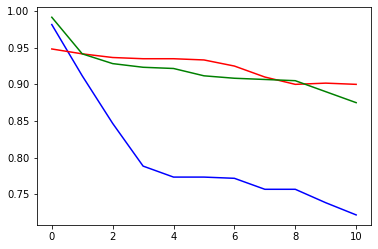

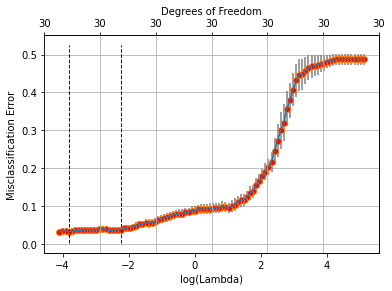

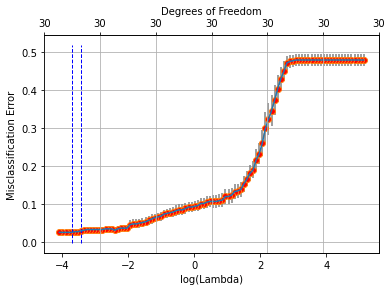

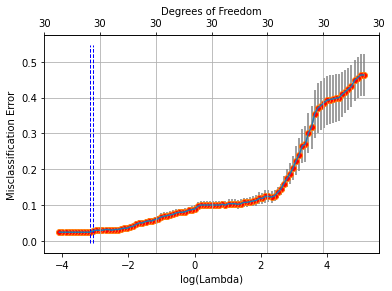

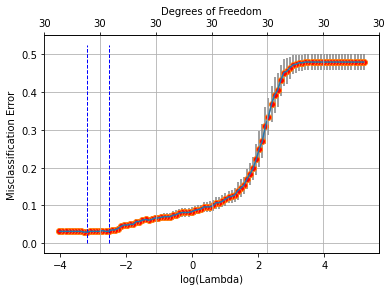

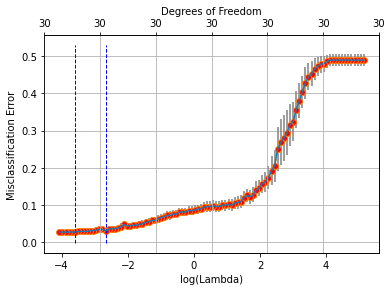

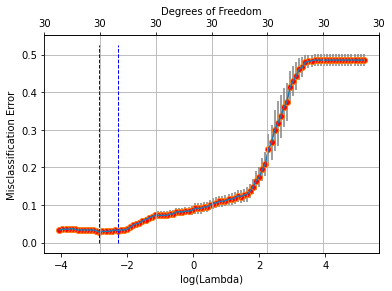

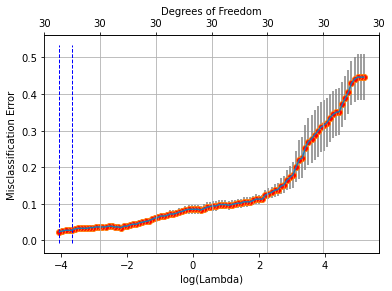

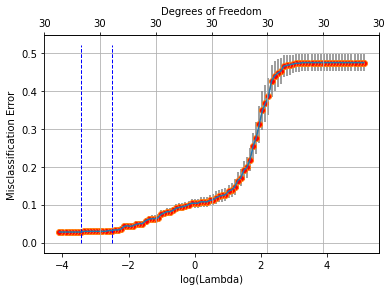

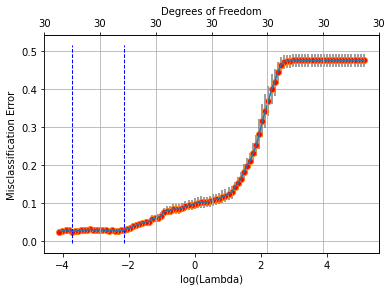

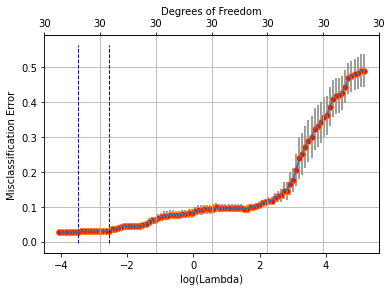

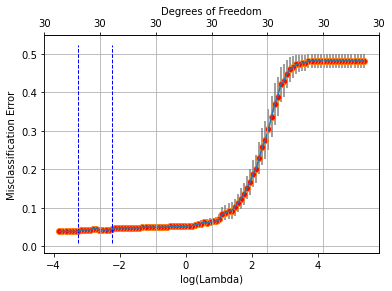

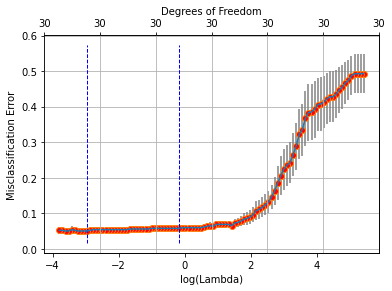

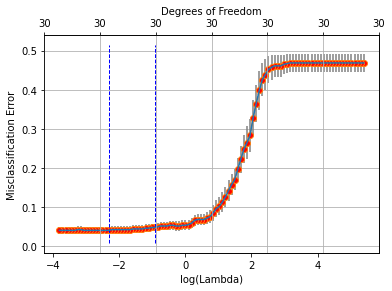

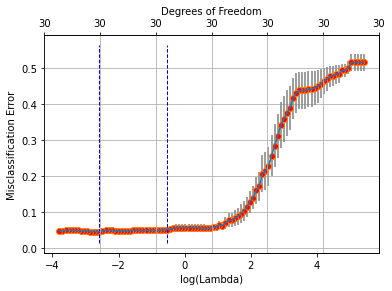

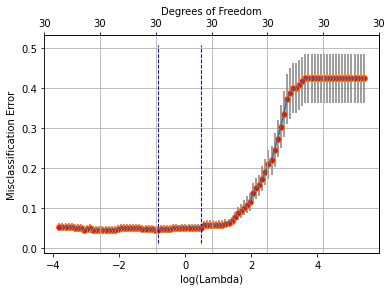

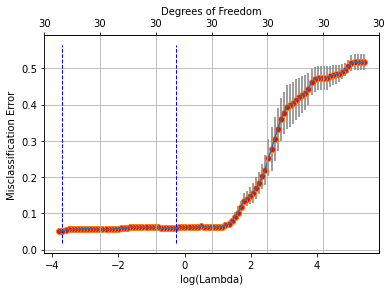

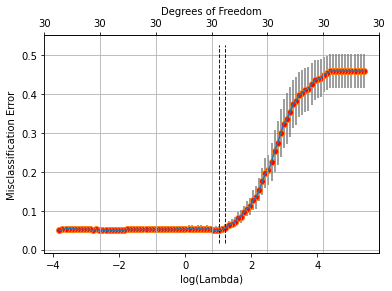

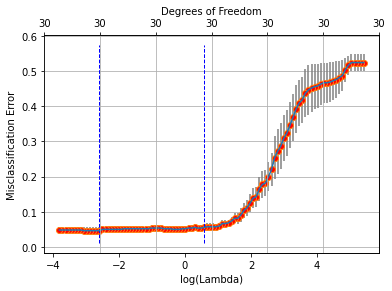

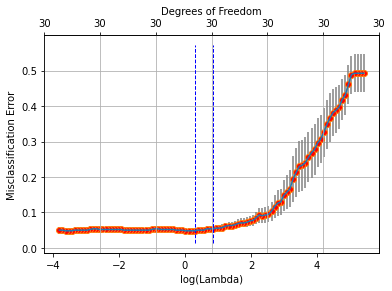

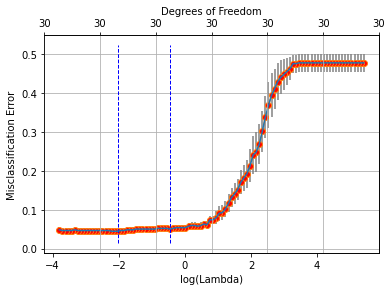

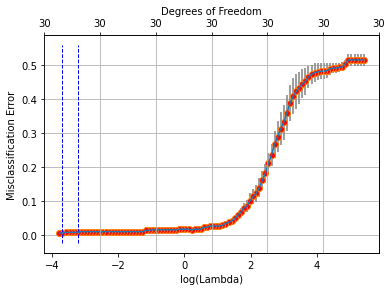

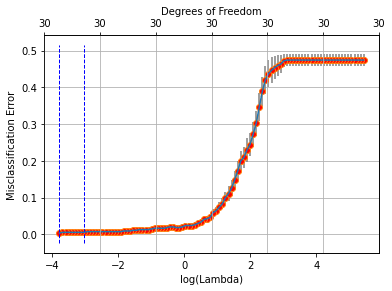

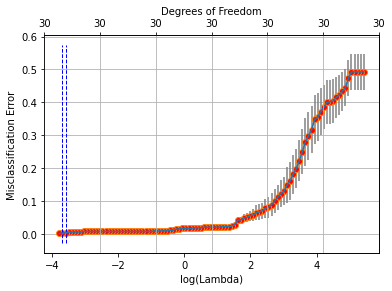

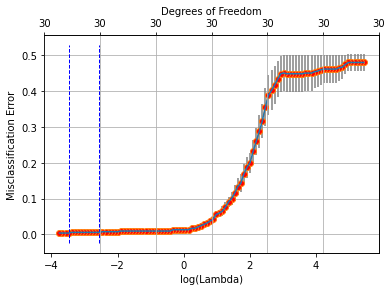

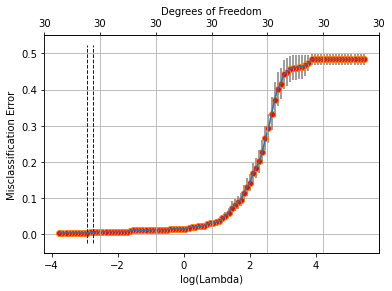

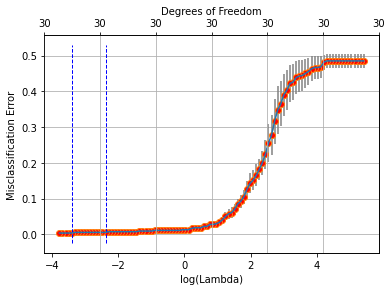

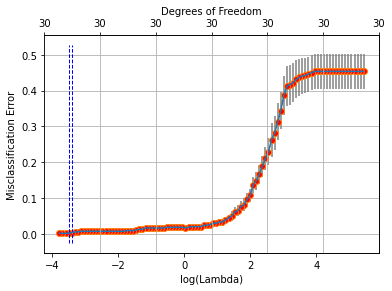

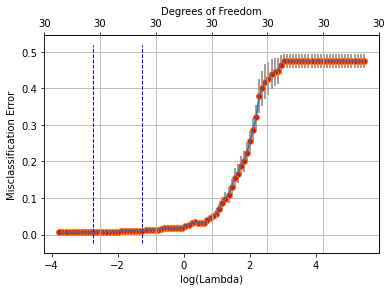

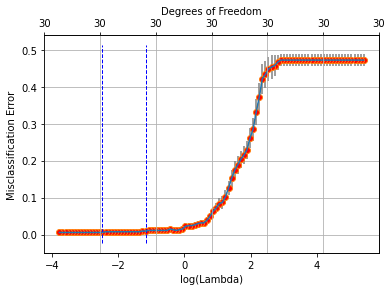

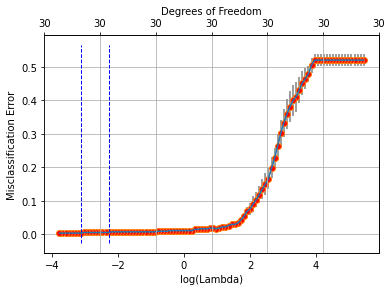

In [13]:
"""
Plots that decide the correct alpha
"""
plt.figure()
plt.plot(range(0,11),PyGLMscore_mean, 'blue')
plt.plot(range(0,11),PyGLMscore_sigMean,'red')
plt.plot(range(0,11),PyGLMscore_voting,'green')

[uniqueTonesSmall_mean, betasSmall_mean, 
 pyGLMbetasSmall_mean,s1_mean,s2_mean] = betaValuesSim(trial_tones_expt,
                                                      idealSubjMeanBhv,
                                                      alpha = (np.argmax(PyGLMscore_mean))*0.1,
                                                      noTau=0, 
                                                      permutations=10)

[uniqueTonesSmall_sigMean, betasSmall_sigMean, 
 pyGLMbetasSmall_sigMean,s1_sigMean,s2_sigMean] = betaValuesSim(trial_tones_expt,
                                                              idealSubjSignalMeanBhv,
                                                              alpha = (np.argmax(PyGLMscore_sigMean))*0.1,
                                                              noTau=0, 
                                                              permutations=10)

[uniqueTonesSmall_voting, betasSmall_voting, 
 pyGLMbetasSmall_voting,s1_voting,s2_voting] = betaValuesSim(trial_tones_expt,
                                                          idealSubjVotingBhv,
                                                          alpha = (np.argmax(PyGLMscore_voting))*0.1,
                                                          noTau=0, 
                                                          permutations=10)

glm scores for no context 0.9633333333333335 0.9833333333333334
Bias terms no : 0.03853103442958756, low : -0.20501333707632508, high : 0.32209371572955525
Norm of distractor weights compared to norm of all weights mean of all strategy 0.7402143011775174
Norm of distractor weights compared to norm of all weights mean of signal strategy 0.2635524930627788
Norm of distractor weights compared to norm of all weights voting strategy 0.49371698870793607


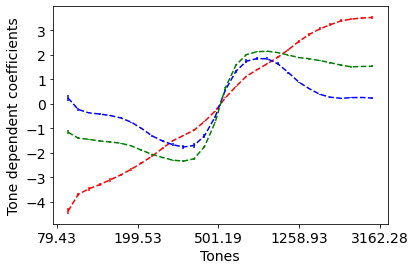

In [20]:
"""
Plots that check for smoothing due to tikhonov
"""
print('glm scores for no context',s1_mean, s2_mean)
#print('glm scores for low context',s1_sigMean, s2_sigMean)
#print('glm scores for high context',s1_voting, s2_voting)
    
plt.figure()
meanShift_no = np.mean(np.mean(pyGLMbetasSmall_mean[:,1:],axis=0))
glmWeights_no = np.mean(pyGLMbetasSmall_mean[:,1:],axis=0)-meanShift_no
plt.errorbar(np.log10(uniqueTonesSmall_mean),
             np.mean(pyGLMbetasSmall_mean[:,1:],axis=0)-meanShift_no, 
             np.std(pyGLMbetasSmall_mean[:,1:],axis=0)/np.sqrt(3), 
             color='red', ls='--')
bias_no = np.mean(pyGLMbetasSmall_mean[:,0]) + 3*meanShift_no

meanShift_low = np.mean(np.mean(pyGLMbetasSmall_sigMean[:,1:],axis=0))
glmWeights_low = np.mean(pyGLMbetasSmall_sigMean[:,1:],axis=0)-meanShift_low
plt.errorbar(np.log10(uniqueTonesSmall_sigMean),
             np.mean(pyGLMbetasSmall_sigMean[:,1:],axis=0)-meanShift_low, 
             np.std(pyGLMbetasSmall_sigMean[:,1:],axis=0)/np.sqrt(3),
             color='blue', ls='--')
bias_low = np.mean(pyGLMbetasSmall_sigMean[:,0]) + 3*meanShift_low

meanShift_high = np.mean(np.mean(pyGLMbetasSmall_voting[:,1:],axis=0))
glmWeights_high = np.mean(pyGLMbetasSmall_voting[:,1:],axis=0)-meanShift_high
plt.errorbar(np.log10(uniqueTonesSmall_voting),
             np.mean(pyGLMbetasSmall_voting[:,1:],axis=0)-meanShift_high, 
             np.std(pyGLMbetasSmall_voting[:,1:],axis=0)/np.sqrt(3),
             color='green', ls='--')
bias_high = np.mean(pyGLMbetasSmall_voting[:,0]) + 3*meanShift_high

print(f"Bias terms no : {bias_no}, low : {bias_low}, high : {bias_high}")
plt.xticks(ticks=np.arange(1.9,3.6,0.4), labels=np.around(10**np.arange(1.9,3.6,0.4),2),fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Tones',fontsize=14)
plt.ylabel('Tone dependent coefficients',fontsize=14)

print("Norm of distractor weights compared to norm of all weights mean of all strategy",
      (sum(np.abs(glmWeights_no[:8]))+sum(np.abs(glmWeights_no[-8:])))/sum(np.abs(glmWeights_no)))

print("Norm of distractor weights compared to norm of all weights mean of signal strategy",
      (sum(np.abs(glmWeights_low[:8]))+sum(np.abs(glmWeights_low[-8:])))/sum(np.abs(glmWeights_low)))

print("Norm of distractor weights compared to norm of all weights voting strategy",
      (sum(np.abs(glmWeights_high[:8]))+sum(np.abs(glmWeights_high[-8:])))/sum(np.abs(glmWeights_high)))

plt.savefig('figures/FromProlific/illustrations/IdealSubject_glmComparisonAcrossStrategies.png')  

In [21]:
import pandas as pd 
pd.DataFrame(np.mean(pyGLMbetasSmall_mean[:,1:],axis=0)-meanShift_no).to_csv("figures/FromProlific/illustrations/IdealSubject_GLMMean.csv")
pd.DataFrame(np.mean(pyGLMbetasSmall_sigMean[:,1:],axis=0)-meanShift_low).to_csv("figures/FromProlific/illustrations/IdealSubject_GLMSigMean.csv")
pd.DataFrame(np.mean(pyGLMbetasSmall_voting[:,1:],axis=0)-meanShift_high).to_csv("figures/FromProlific/illustrations/IdealSubject_GLMVoting.csv")